# 🔍 Misconfiguration Detection in Terraform Configuration Files

## 🧠 Project Overview

This project aims to **automatically detect misconfigurations in Terraform configuration files** using advanced AI techniques, including **Large Language Models (LLMs)** and code-aware agents.

Although similar efforts have been made in the Kubernetes ecosystem, this work **focuses on Terraform**, particularly infrastructure-as-code (IaC) scripts used with Oracle Cloud Infrastructure (OCI).

---

## 📥 Input

We are given a dataset of **10,000 Terraform configuration files**, each labeled with one or more **misconfiguration tags**.
These labels follow the [Checkov](https://www.checkov.io/) convention, a static analysis tool for IaC.

Each sample in the dataset is a JSON object of the form:

json
{
  "path/to/file.tf": {
    "content": "<Terraform HCL code as string>",
    "checkov_ids": ["CKV_OCI_4", "CKV_OCI_6"]
  }
}


### 🔸 Sample Fields

* **File Path**: Logical path within a repository (e.g., terraform-talos/oracle/instances-controlplane.tf)
* **content**: Raw HCL configuration script, possibly spanning multiple resources and data blocks
* **checkov_ids**: List of static analysis findings, indicating potential security or configuration issues

---

## 🧾 Misconfig ID Reference

The checkov_ids field contains codes corresponding to known misconfigurations:

* CKV_OCI_4: Missing network security group
* CKV_OCI_6: Public IP assignment without justification
* CKV_OCI_7: Versioning should be enabled for buckets
* CKV_OCI_8: Object lifecycle policies should be defined
* CKV_OCI_9: Buckets should not be publicly accessible

---

## ✅ Goal

Develop a method to:

* **Parse and analyze** Terraform HCL code (possibly across multiple files)
* **Learn patterns** of misconfigurations using AI/LLMs or static/dynamic hybrid techniques
* **Predict relevant Checkov IDs** (multi-label classification)
* Optionally **generate explainable feedback** or propose auto-fixes

---

## 🧠 AI Techniques Allowed

You are not limited to one modeling approach. Consider exploring:

* Prompt engineering or fine-tuning LLMs (e.g., CodeLlama, StarCoder)
* Tree-structured parsing and transformer encodings (e.g., AST-based models)
* Graph-based learning (resources as nodes, dependencies as edges)
* Hybrid static + semantic analysis agents

---

## 🧪 Example: instances-controlplane.tf

This file provisions instances and networking components in OCI, including:

* **Instance creation** (oci_core_instance)
* **Load balancer backend registration**
* **IPv6 assignment and metadata templating**

Associated misconfigs:

* CKV_OCI_6: May refer to public IP assignment
* CKV_OCI_4: May relate to improper NSG usage

---

## 🔎 Challenges

* Multi-label classification
* Complex nested HCL structures
* Templates, dynamic expressions, and locals
* High class imbalance across Checkov IDs

---

## 📂 Suggested Notebook Structure

1. **Data Loading and Exploration**
2. **Parsing Terraform** (e.g., using hcl2, tree-sitter, or tflint)
3. **Misconfig Pattern Analysis**
4. **Baseline Classifier** (e.g., TF-IDF + Logistic Regression)
5. **LLM Evaluation** (zero-shot, few-shot)
6. **Explainability + Visualization**
7. **Results + Metrics** (Precision\@K, Macro-F1, etc.)

# Imports 

In [1]:
# Standard library imports
import os
import sys
import json
import time
import pickle
import copy
from datetime import datetime
from collections import Counter
from typing import Tuple, List

# Data processing and scientific computing
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    classification_report, multilabel_confusion_matrix,
    f1_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

# Gradient boosting libraries
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Deep learning and transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoModel, AutoTokenizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Progress bars
from tqdm import tqdm


/Users/adirserruya/Projects/misconfig_detection/.cyber_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility Functions 

In [2]:
def load_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def extract_unique_labels(data):
    """
    Extract unique labels from the dataset.
    
    Args:
        data: Dictionary containing the dataset
        
    Returns:
        list: Sorted list of unique labels
    """
    unique_labels = set()
    for item in tqdm(data.items(), desc="Processing items"):
        content = item[1]['content']
        labels = item[1]['checkov_ids']
        unique_labels.update(labels)
    unique_labels = sorted(unique_labels)
    print(f"Unique labels: {len(unique_labels)}")
    return unique_labels

def chunk_and_embed(texts, tokenizer, model, max_length=512, stride=256):
    all_embeddings = []
    
    for text in tqdm(texts, desc="Processing texts"):
        # Tokenize with overlap
        tokens = tokenizer(text, return_tensors="pt", 
                         truncation=False)  # Don't truncate initially
        
        if tokens.input_ids.size(1) <= max_length:
            # If text is short enough, process it directly
            outputs = model(**tokens)
            embedding = outputs.last_hidden_state[:, 0, :]  # Get CLS token
            all_embeddings.append(embedding)
        else:
            # For long texts, process in chunks
            chunk_embeddings = []
            for i in range(0, tokens.input_ids.size(1), stride):
                chunk = {k: v[:, i:i+max_length] for k, v in tokens.items()}
                if chunk['input_ids'].size(1) < 10:  # Skip very small chunks
                    continue
                outputs = model(**chunk)
                chunk_embeddings.append(outputs.last_hidden_state[:, 0, :])
            
            # Average the embeddings from all chunks
            avg_embedding = torch.mean(torch.stack(chunk_embeddings, dim=0), dim=0)
            all_embeddings.append(avg_embedding)
    
    return torch.stack(all_embeddings, dim=0)

def process_batch(texts, tokenizer, model, batch_size=32, max_length=512, stride=256, save_path='./data/embeddings/'):
    os.makedirs(save_path, exist_ok=True)
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = chunk_and_embed(batch_texts, tokenizer, model, max_length, stride)
        
        # Save this batch
        torch.save(batch_embeddings, f'{save_path}batch_{i}.pt')
        
        # Clear CUDA cache if using GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def combine_embeddings(num_batches, batch_size, total_samples, save_path='./data/embeddings/'):
    all_embeddings = []
    
    for i in tqdm(range(0, num_batches * batch_size, batch_size), desc="Combining batches"):
        try:
            batch_embeddings = torch.load(f'{save_path}batch_{i}.pt')
            all_embeddings.append(batch_embeddings)
        except FileNotFoundError:
            print(f"Batch {i} not found, skipping...")
            continue
            
    combined = torch.cat(all_embeddings, dim=0)
    # Trim any extra samples
    combined = combined[:total_samples]
    
    return combined

def create_label_matrix(y_data: list, unique_labels: list) -> torch.Tensor:
    """
    Create a binary matrix where rows are samples and columns are unique labels.
    
    Args:
        y_data: List of label lists, where each inner list contains labels for one sample
        unique_labels: List of all unique labels
        
    Returns:
        torch.Tensor: Binary matrix of shape (n_samples, n_labels)
    """
    # Create a binary matrix where rows are samples and columns are unique labels
    y_matrix = torch.zeros((len(y_data), len(unique_labels)))
    
    for i, labels in enumerate(y_data):
        for label in labels:
            # Get the index of the label in unique_labels
            label_idx = unique_labels.index(label)
            y_matrix[i, label_idx] = 1

    # Convert to float for training
    y_matrix = y_matrix.float()
    
    print(f"Shape of y_matrix: {y_matrix.shape}")
    print(f"Number of positive labels: {y_matrix.sum()}")
    
    return y_matrix



def create_experiment_folder():
    """Create folder for experiment results"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"ml_experiment_{timestamp}"
    os.makedirs(folder_name, exist_ok=True)
    return folder_name

def save_experiment_data(results, folder_path):
    """Save all experiment data"""
    # Save hyperparameters
    hyperparams = {
        'rf': {'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
        'lgbm': {'n_estimators': 100, 'max_depth': 6, 'random_state': 42},
        'xgb': {'n_estimators': 100, 'max_depth': 6, 'random_state': 42},
        'catboost': {'iterations': 100, 'depth': 6, 'random_state': 42}
    }
    
    with open(f"{folder_path}/hyperparameters.json", 'w') as f:
        json.dump(hyperparams, f, indent=2)
    
    # Save metrics summary
    metrics_summary = {}
    for model_name, result in results.items():
        metrics_summary[model_name] = {
            'f1': float(result['f1']),
            'precision': float(result['precision']),
            'recall': float(result['recall']),
            'training_time': float(result['training_time'])
        }
    
    with open(f"{folder_path}/metrics_summary.json", 'w') as f:
        json.dump(metrics_summary, f, indent=2)
    
    # Save models
    for model_name, result in results.items():
        if 'model' in result:  # Single model (RF)
            with open(f"{folder_path}/{model_name}_model.pkl", 'wb') as f:
                pickle.dump(result['model'], f)
        elif 'models' in result:  # Multiple models (LGBM, XGB, CatBoost)
            with open(f"{folder_path}/{model_name}_models.pkl", 'wb') as f:
                pickle.dump(result['models'], f)
        
        # Save predictions
        np.save(f"{folder_path}/{model_name}_predictions.npy", result['predictions'])

def train_traditional_models(X_train, X_val, y_train, y_val, models_to_train=['rf', 'lgbm', 'xgb', 'catboost']):
    """
    Train traditional ML models for multi-label classification
    """
    results = {}
    
    # Convert tensors to numpy if needed
    if torch.is_tensor(X_train):
        X_train = X_train.numpy()
    if torch.is_tensor(X_val):
        X_val = X_val.numpy()
    if torch.is_tensor(y_train):
        y_train = y_train.numpy()
    if torch.is_tensor(y_val):
        y_val = y_val.numpy()
    
    print(f"Training traditional models on {X_train.shape[0]} samples with {X_train.shape[1]} features")
    print(f"Target shape: {y_train.shape}")
    
    if 'rf' in models_to_train:
        print("\n=== Training Random Forest ===")
        start_time = time.time()
        rf = MultiOutputClassifier(RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ))
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_val)
        rf_time = time.time() - start_time
        
        rf_f1 = f1_score(y_val, rf_pred, average='macro', zero_division=0)
        rf_precision = precision_score(y_val, rf_pred, average='macro', zero_division=0)
        rf_recall = recall_score(y_val, rf_pred, average='macro', zero_division=0)
        
        results['rf'] = {
            'model': rf,
            'predictions': rf_pred,
            'f1': rf_f1,
            'precision': rf_precision,
            'recall': rf_recall,
            'training_time': rf_time
        }
        print(f"RF - F1: {rf_f1:.4f}, Precision: {rf_precision:.4f}, Recall: {rf_recall:.4f}, Time: {rf_time:.2f}s")
    
    if 'lgbm' in models_to_train:
        print("\n=== Training LightGBM ===")
        start_time = time.time()
        lgbm_models = []
        lgbm_pred = np.zeros_like(y_val)
        
        for i in tqdm(range(y_train.shape[1]), desc="Training LGBM models"):
            lgbm_model = lgb.LGBMClassifier(
                n_estimators=100,
                max_depth=6,
                random_state=42,
                verbose=-1
            )
            lgbm_model.fit(X_train, y_train[:, i])
            lgbm_pred[:, i] = lgbm_model.predict(X_val)
            lgbm_models.append(lgbm_model)
        
        lgbm_time = time.time() - start_time
        lgbm_f1 = f1_score(y_val, lgbm_pred, average='macro', zero_division=0)
        lgbm_precision = precision_score(y_val, lgbm_pred, average='macro', zero_division=0)
        lgbm_recall = recall_score(y_val, lgbm_pred, average='macro', zero_division=0)
        
        results['lgbm'] = {
            'models': lgbm_models,
            'predictions': lgbm_pred,
            'f1': lgbm_f1,
            'precision': lgbm_precision,
            'recall': lgbm_recall,
            'training_time': lgbm_time
        }
        print(f"LGBM - F1: {lgbm_f1:.4f}, Precision: {lgbm_precision:.4f}, Recall: {lgbm_recall:.4f}, Time: {lgbm_time:.2f}s")
    
    if 'xgb' in models_to_train:
        print("\n=== Training XGBoost ===")
        start_time = time.time()
        xgb_models = []
        xgb_pred = np.zeros_like(y_val)
        
        for i in tqdm(range(y_train.shape[1]), desc="Training XGB models"):
            xgb_model = xgb.XGBClassifier(
                n_estimators=100,
                max_depth=6,
                random_state=42,
                eval_metric='logloss'
            )
            xgb_model.fit(X_train, y_train[:, i])
            xgb_pred[:, i] = xgb_model.predict(X_val)
            xgb_models.append(xgb_model)
        
        xgb_time = time.time() - start_time
        xgb_f1 = f1_score(y_val, xgb_pred, average='macro', zero_division=0)
        xgb_precision = precision_score(y_val, xgb_pred, average='macro', zero_division=0)
        xgb_recall = recall_score(y_val, xgb_pred, average='macro', zero_division=0)
        
        results['xgb'] = {
            'models': xgb_models,
            'predictions': xgb_pred,
            'f1': xgb_f1,
            'precision': xgb_precision,
            'recall': xgb_recall,
            'training_time': xgb_time
        }
        print(f"XGB - F1: {xgb_f1:.4f}, Precision: {xgb_precision:.4f}, Recall: {xgb_recall:.4f}, Time: {xgb_time:.2f}s")
    
    if 'catboost' in models_to_train:
        print("\n=== Training CatBoost ===")
        start_time = time.time()
        cb_models = []
        cb_pred = np.zeros_like(y_val)
        
        for i in tqdm(range(y_train.shape[1]), desc="Training CatBoost models"):
            cb_model = cb.CatBoostClassifier(
                iterations=100,
                depth=6,
                random_state=42,
                verbose=False
            )
            cb_model.fit(X_train, y_train[:, i])
            cb_pred[:, i] = cb_model.predict(X_val)
            cb_models.append(cb_model)
        
        cb_time = time.time() - start_time
        cb_f1 = f1_score(y_val, cb_pred, average='macro', zero_division=0)
        cb_precision = precision_score(y_val, cb_pred, average='macro', zero_division=0)
        cb_recall = recall_score(y_val, cb_pred, average='macro', zero_division=0)
        
        results['catboost'] = {
            'models': cb_models,
            'predictions': cb_pred,
            'f1': cb_f1,
            'precision': cb_precision,
            'recall': cb_recall,
            'training_time': cb_time
        }
        print(f"CatBoost - F1: {cb_f1:.4f}, Precision: {cb_precision:.4f}, Recall: {cb_recall:.4f}, Time: {cb_time:.2f}s")
    
    return results

# Print model summary
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            trainable_params += num_params
        print(f'{name}: {param.shape} ({num_params} parameters)')
    
    print(f'\nTotal parameters: {total_params:,}')
    print(f'Trainable parameters: {trainable_params:,}')

# Get all weights as a single vector
def get_weights_vector(model):
    weights = []
    for param in model.parameters():
        weights.append(param.data.view(-1))
    return torch.cat(weights)

In [3]:
data = load_json('./data/filtered_selected_7k_files.json')

In [4]:
# Extract unique labels
unique_labels = extract_unique_labels(data)

Processing items: 100%|██████████| 7465/7465 [00:00<00:00, 922769.13it/s]

Unique labels: 1061


Counting labels: 100%|██████████| 7465/7465 [00:00<00:00, 122767.90it/s]


Total unique labels: 1061
Total counts: 38163
Top 50 labels: 50
Labels: ('CKV_OCI_6', 'CKV_OCI_4', 'CKV_OCI_9', 'CKV_OCI_7', 'CKV_OCI_8', 'CKV_GCP_32', 'CKV_GCP_40', 'CKV_GCP_76', 'CKV_GCP_26', 'CKV2_GCP_18', 'CKV_GCP_114', 'CKV_GCP_62', 'CKV_GCP_49', 'CKV_GCP_117', 'CKV_GCP_36', 'CKV_TF_1', 'CKV_LIN_2', 'CKV_AZURE_179', 'CKV_AZURE_97', 'CKV_AZURE_49', 'CKV_AZURE_206', 'CKV_AZURE_44', 'CKV_AZURE_59', 'CKV_AZURE_33', 'CKV2_AZURE_33', 'CKV2_AZURE_1', 'CKV2_AZURE_21', 'CKV2_AZURE_38', 'CKV_AZURE_164', 'CKV_AZURE_166', 'CKV_AZURE_163', 'CKV_AZURE_139', 'CKV_AZURE_165', 'CKV_AZURE_233', 'CKV_AZURE_167', 'CKV_AZURE_237', 'CKV_AZURE_77', 'CKV_AZURE_118', 'CKV_AZURE_119', 'CKV_AZURE_190', 'CKV2_AZURE_40', 'CKV2_AZURE_47', 'CKV2_AZURE_41', 'CKV_AZURE_50', 'CKV_DIO_4', 'CKV_GCP_38', 'CKV_GCP_39', 'CKV_GCP_2', 'CKV_GCP_106', 'CKV_AWS_130', 'CKV2_AWS_11', 'CKV2_AWS_12', 'CKV_AWS_150', 'CKV_AWS_91', 'CKV2_AWS_20', 'CKV_AWS_79', 'CKV_AWS_135', 'CKV_AWS_88', 'CKV_AWS_126', 'CKV2_AWS_41', 'CKV_K8S_43'

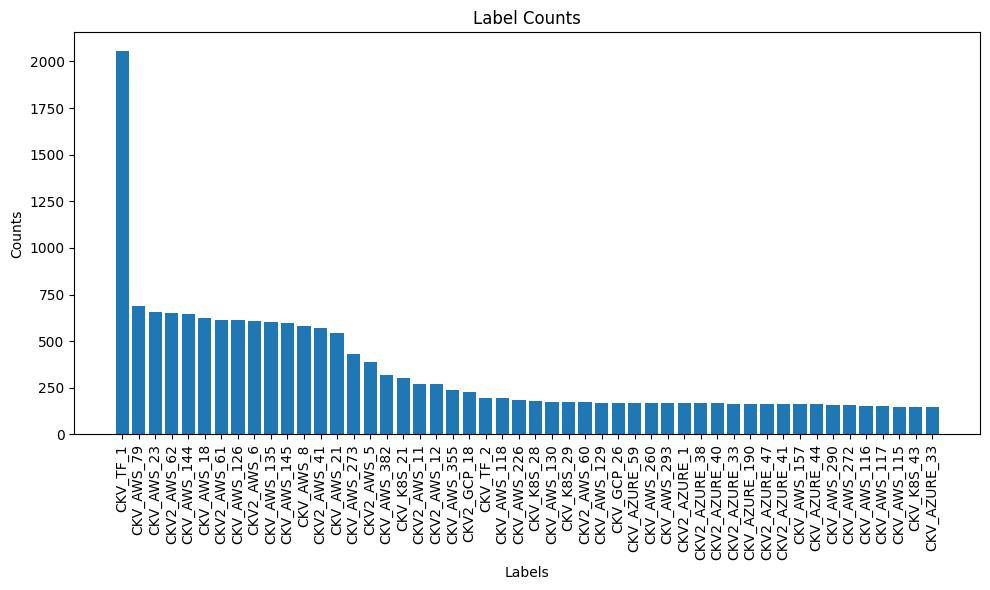

In [5]:
label_counts = Counter()
for item in tqdm(data.items(), desc="Counting labels"):
    labels = item[1]['checkov_ids']
    label_counts.update(labels)
label_counts = dict(label_counts)
labels, counts = zip(*label_counts.items())
top_50_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:50]
labels_top, counts_top = zip(*top_50_labels)
print(f"Total unique labels: {len(labels)}")
print(f"Total counts: {sum(counts)}")
print(f"Top 50 labels: {len(top_50_labels)}")
print("Labels:", labels)
print("Counts:", counts)

plt.figure(figsize=(10, 6))
plt.bar(labels_top, counts_top)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

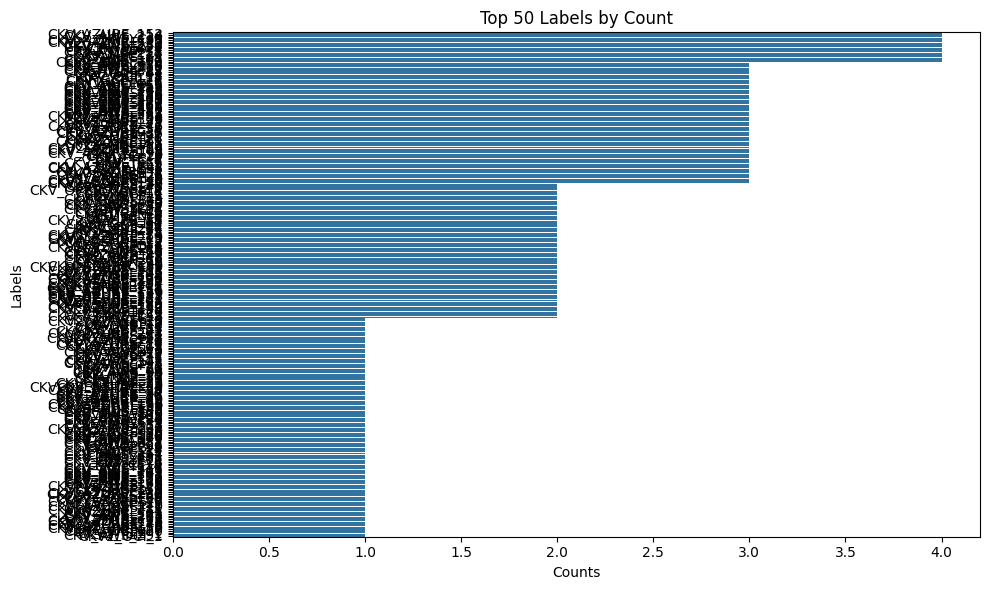

In [6]:
label_counts_df = pd.DataFrame({
    'label': labels,
    'count': counts
})
label_counts_df = label_counts_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='label', data=label_counts_df.tail(300))
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title('Top 50 Labels by Count')
plt.tight_layout()
plt.show()

In [7]:
# Find labels with less than 20 samples and their corresponding indices
rare_labels = []
rare_label_indices = []

for i, label in enumerate(unique_labels):
    count = label_counts[label]
    if count < 20:
        rare_labels.append(label)
        rare_label_indices.append(i)

print(f"Number of rare labels (< 20 samples): {len(rare_labels)}")
print(f"Total labels: {len(unique_labels)}")
print(f"Percentage of rare labels: {len(rare_labels)/len(unique_labels)*100:.1f}%")

print(f"\nRare labels and their counts:")
for label in rare_labels[:20]:  # Show first 20
    print(f"{label}: {label_counts[label]} samples")

if len(rare_labels) > 20:
    print(f"... and {len(rare_labels) - 20} more")

print(f"\nCorresponding indices: {rare_label_indices[:20]}")
if len(rare_label_indices) > 20:
    print(f"... and {len(rare_label_indices) - 20} more indices")

Number of rare labels (< 20 samples): 726
Total labels: 1061
Percentage of rare labels: 68.4%

Rare labels and their counts:
CKV2_ADO_1: 2 samples
CKV2_AWS_1: 15 samples
CKV2_AWS_14: 9 samples
CKV2_AWS_15: 4 samples
CKV2_AWS_18: 1 samples
CKV2_AWS_2: 6 samples
CKV2_AWS_21: 9 samples
CKV2_AWS_22: 2 samples
CKV2_AWS_27: 15 samples
CKV2_AWS_29: 13 samples
CKV2_AWS_3: 13 samples
CKV2_AWS_31: 5 samples
CKV2_AWS_33: 7 samples
CKV2_AWS_35: 3 samples
CKV2_AWS_36: 1 samples
CKV2_AWS_37: 5 samples
CKV2_AWS_4: 18 samples
CKV2_AWS_40: 18 samples
CKV2_AWS_43: 2 samples
CKV2_AWS_44: 5 samples
... and 706 more

Corresponding indices: [0, 1, 5, 6, 8, 10, 12, 13, 15, 17, 18, 20, 22, 24, 25, 26, 29, 30, 33, 34]
... and 706 more indices


# Extracting Dataset from JSON

In [ ]:
# Building X and Y
X,y = [], []
for item in tqdm(data.items(), desc="Processing items"):
    content = item[1]['content']
    labels = item[1]['checkov_ids']
    X.append(content)
    y.append(labels)


# Saving a sample

In [ ]:
with open('./data/example.tf', 'w') as f:
    content = X[0]
    f.write(content)


# Creating the embedding from a pretrained LLM

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
# Process in batches of 32
batch_size = 2
texts = [x for x in X if x.strip()]  # Filter empty strings
num_batches = (len(texts) + batch_size - 1) // batch_size

# Process all batches
process_batch(texts, tokenizer, model, batch_size=batch_size,stride=512)

# Combine all batches
outputs = combine_embeddings(num_batches, batch_size, len(texts))
torch.save(outputs, './data/embeddings.pt')

# Save

In [ ]:
# Save both tensors to data folder
torch.save(X, './data/X_embeddings.pt')
torch.save(y_matrix, './data/y_matrix.pt')

print(f"Saved X with shape: {X.shape}")
print(f"Saved y_matrix with shape: {y_matrix.shape}")

# Load tensors from data folder

In [8]:
X = torch.load('/Users/adirserruya/Projects/misconfig_detection/data/X_embeddings.pt')
y_matrix = torch.load('/Users/adirserruya/Projects/misconfig_detection/data/y_matrix.pt')
X = X.squeeze(1)  # Remove redundant dimension
X = X.detach().numpy()
y_matrix = y_matrix.detach().numpy()

# Filtering Rare Labels by editing the labels

In [9]:
# Create a cleaner dataset by setting rare labels to 0 instead of removing samples
print("Creating cleaner dataset by setting rare labels to 0...")

# Create a copy of the original matrices
X_clean = X.copy()
y_matrix_clean = y_matrix.copy()

# Set all rare labels to 0 in the y_matrix
for rare_idx in tqdm(rare_label_indices, desc="Setting rare labels to 0"):
    y_matrix_clean[:, rare_idx] = 0

# Remove the rare label columns entirely to create a smaller label space
frequent_label_mask = np.ones(len(unique_labels), dtype=bool)
frequent_label_mask[rare_label_indices] = False

y_matrix_clean = y_matrix_clean[:, frequent_label_mask]

# Update unique_labels to only include frequent labels
frequent_labels = [unique_labels[i] for i in range(len(unique_labels)) if frequent_label_mask[i]]

print(f"Original dataset: {X.shape[0]} samples, {len(unique_labels)} labels")
print(f"Clean dataset: {X_clean.shape[0]} samples, {len(frequent_labels)} labels")
print(f"Removed 0 samples (kept all samples)")
print(f"Removed {len(rare_labels)} rare labels ({len(rare_labels)/len(unique_labels)*100:.1f}%)")

# Verify no samples have zero labels after cleaning
labels_per_sample = np.sum(y_matrix_clean, axis=1)
zero_label_samples = np.sum(labels_per_sample == 0)
print(f"Samples with zero labels after cleaning: {zero_label_samples}")
print(f"Average labels per sample: {labels_per_sample.mean():.2f}")
print(f"Min labels per sample: {labels_per_sample.min()}")
print(f"Max labels per sample: {labels_per_sample.max()}")

# Show distribution of remaining labels
remaining_label_counts = np.sum(y_matrix_clean, axis=1)
print(f"\nRemaining label statistics:")
print(f"Min count: {remaining_label_counts.min()}")
print(f"Max count: {remaining_label_counts.max()}")
print(f"Mean count: {remaining_label_counts.mean():.1f}")

# Save the clean dataset
print(f"\nSaving clean dataset...")
np.save('./data/X_clean.npy', X_clean)
np.save('./data/y_matrix_clean.npy', y_matrix_clean)

with open('./data/frequent_labels.json', 'w') as f:
    json.dump(frequent_labels, f, indent=2)

print("Clean dataset saved successfully!")


Creating cleaner dataset by setting rare labels to 0...


Setting rare labels to 0: 100%|██████████| 726/726 [00:00<00:00, 69306.83it/s]

Original dataset: 7465 samples, 1061 labels
Clean dataset: 7465 samples, 335 labels
Removed 0 samples (kept all samples)
Removed 726 rare labels (68.4%)
Samples with zero labels after cleaning: 1197
Average labels per sample: 2.89
Min labels per sample: 0.0
Max labels per sample: 34.0

Remaining label statistics:
Min count: 0.0
Max count: 34.0
Mean count: 2.9

Saving clean dataset...
Clean dataset saved successfully!


In [10]:
# Find indices where the value is 1 in the first sample
indices_of_ones = [i for i, val in enumerate(y_matrix[1]) if val == 1.0]
print(f"Indices where y_matrix[0] equals 1: {indices_of_ones}")

# If you want to see the corresponding label names
if indices_of_ones:
    label_names = [unique_labels[i] for i in indices_of_ones]
    print(f"Label names for first sample: {label_names}")
else:
    print("No labels found for the first sample")

Indices where y_matrix[0] equals 1: [1010, 1012]
Label names for first sample: ['CKV_OCI_7', 'CKV_OCI_9']


In [11]:
indices_of_ones = [i for i, val in enumerate(y_matrix_clean[1]) if val == 1.0]
print(f"Indices where y_matrix_clean[0] equals 1: {indices_of_ones}")
# If you want to see the corresponding label names
if indices_of_ones:
    label_names_clean = [frequent_labels[i] for i in indices_of_ones]
    print(f"Label names for first sample in clean dataset: {label_names_clean}")
else:
    print("No labels found for the first sample in clean dataset")

Indices where y_matrix_clean[0] equals 1: [327, 329]
Label names for first sample in clean dataset: ['CKV_OCI_7', 'CKV_OCI_9']


In [12]:
'CKV_OCI_6' in rare_labels  # Check if a specific label is in the rare labels

True

# K means clustering, trying different K and analyzing results via visualizations (Linear and Non Linear)

Computing clustering metrics for different k values...


Computing metrics:  17%|█▋        | 1/6 [00:02<00:14,  2.93s/it]

k=2: Silhouette=0.359, Calinski-Harabasz=4528.3


Computing metrics:  33%|███▎      | 2/6 [00:06<00:12,  3.16s/it]

k=3: Silhouette=0.208, Calinski-Harabasz=3330.2


Computing metrics:  50%|█████     | 3/6 [00:10<00:10,  3.46s/it]

k=4: Silhouette=0.137, Calinski-Harabasz=2595.6


Computing metrics:  67%|██████▋   | 4/6 [00:14<00:08,  4.03s/it]

k=5: Silhouette=0.129, Calinski-Harabasz=2218.8


Computing metrics:  83%|████████▎ | 5/6 [00:20<00:04,  4.51s/it]

k=6: Silhouette=0.121, Calinski-Harabasz=1932.2


Computing metrics: 100%|██████████| 6/6 [00:26<00:00,  4.36s/it]

k=7: Silhouette=0.109, Calinski-Harabasz=1710.1


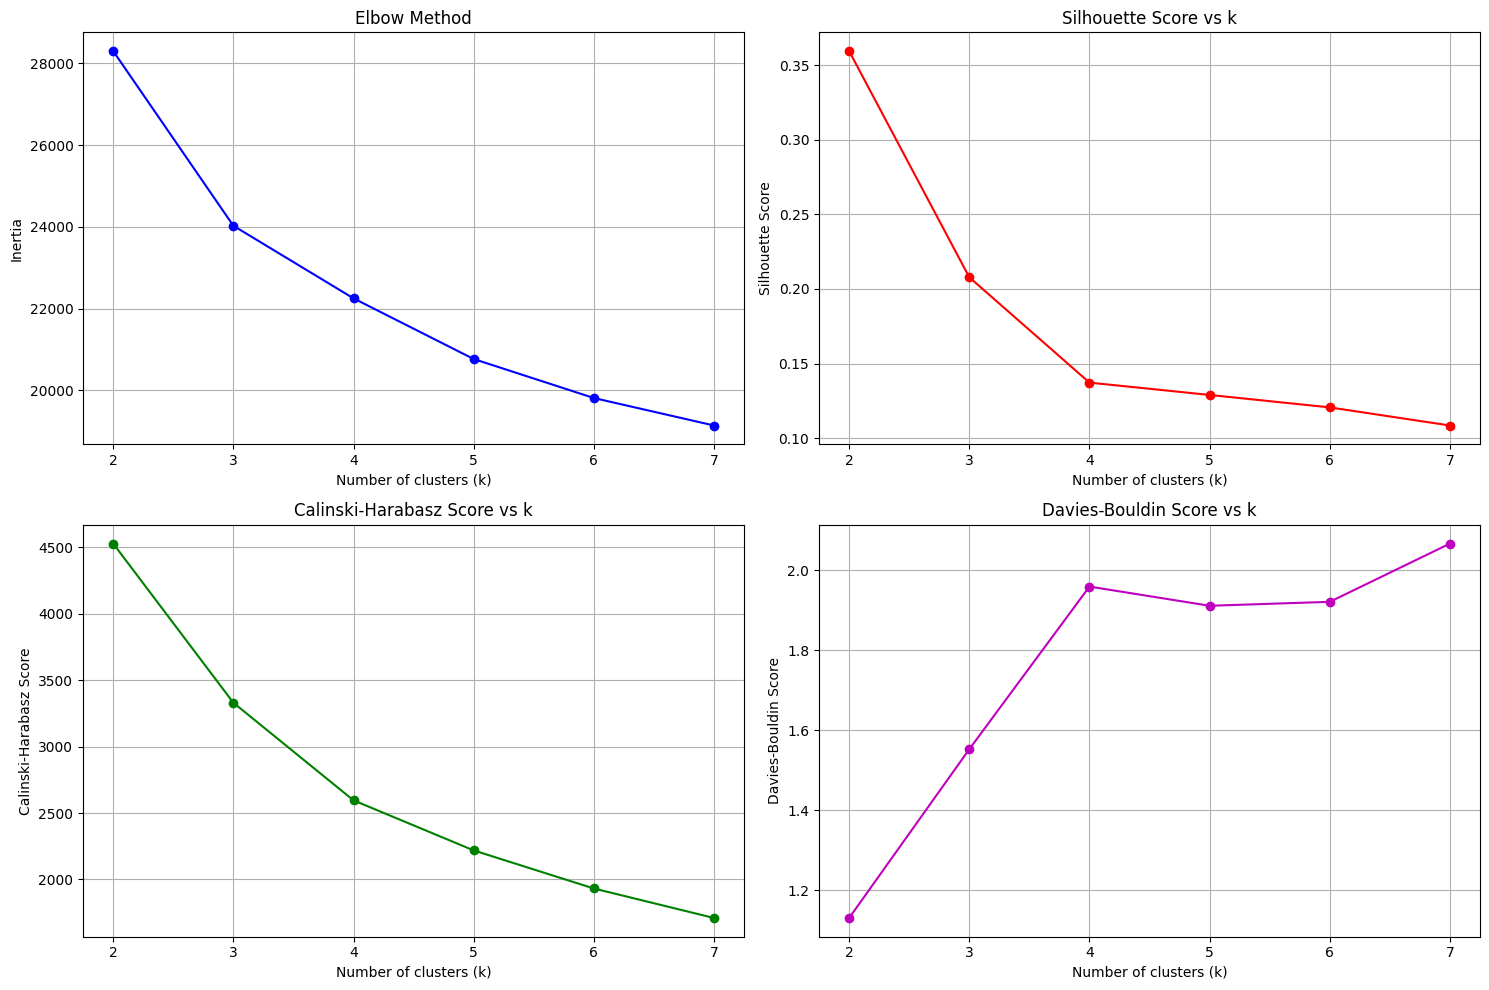


=== K-means clustering with k=7 ===
Silhouette Score: 0.1085
Calinski-Harabasz Score: 1710.12
Davies-Bouldin Score: 2.0663
Inertia: 19140.14

Cluster distribution:
Cluster 0: 1222 samples (16.4%)
Cluster 1: 1312 samples (17.6%)
Cluster 2: 231 samples (3.1%)
Cluster 3: 1640 samples (22.0%)
Cluster 4: 1345 samples (18.0%)
Cluster 5: 916 samples (12.3%)
Cluster 6: 799 samples (10.7%)


In [13]:
# Elbow method to find optimal number of clusters
k_range = range(2, 8)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("Computing clustering metrics for different k values...")
for k in tqdm(k_range, desc="Computing metrics"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X, cluster_labels))
    
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, Calinski-Harabasz={calinski_scores[-1]:.1f}")

# Plot elbow curve and metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'bo-')
axes[0, 0].set_xlabel('Number of clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, 'ro-')
axes[0, 1].set_xlabel('Number of clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score vs k')
axes[0, 1].grid(True)

# Calinski-Harabasz score
axes[1, 0].plot(k_range, calinski_scores, 'go-')
axes[1, 0].set_xlabel('Number of clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score vs k')
axes[1, 0].grid(True)

# Davies-Bouldin score
axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-')
axes[1, 1].set_xlabel('Number of clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score vs k')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Perform K-means with k=7
print("\n=== K-means clustering with k=7 ===")
kmeans_10 = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_labels_10 = kmeans_10.fit_predict(X)

# Calculate metrics for k=7
silhouette_10 = silhouette_score(X, cluster_labels_10)
calinski_10 = calinski_harabasz_score(X, cluster_labels_10)
davies_bouldin_10 = davies_bouldin_score(X, cluster_labels_10)
inertia_10 = kmeans_10.inertia_

print(f"Silhouette Score: {silhouette_10:.4f}")
print(f"Calinski-Harabasz Score: {calinski_10:.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin_10:.4f}")
print(f"Inertia: {inertia_10:.2f}")

# Cluster distribution
cluster_counts = np.bincount(cluster_labels_10)
print(f"\nCluster distribution:")
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} samples ({count/len(cluster_labels_10)*100:.1f}%)")

# Store cluster labels for further analysis
cluster_labels = cluster_labels_10

# PCA and Visualization 

Performing PCA for visualization...


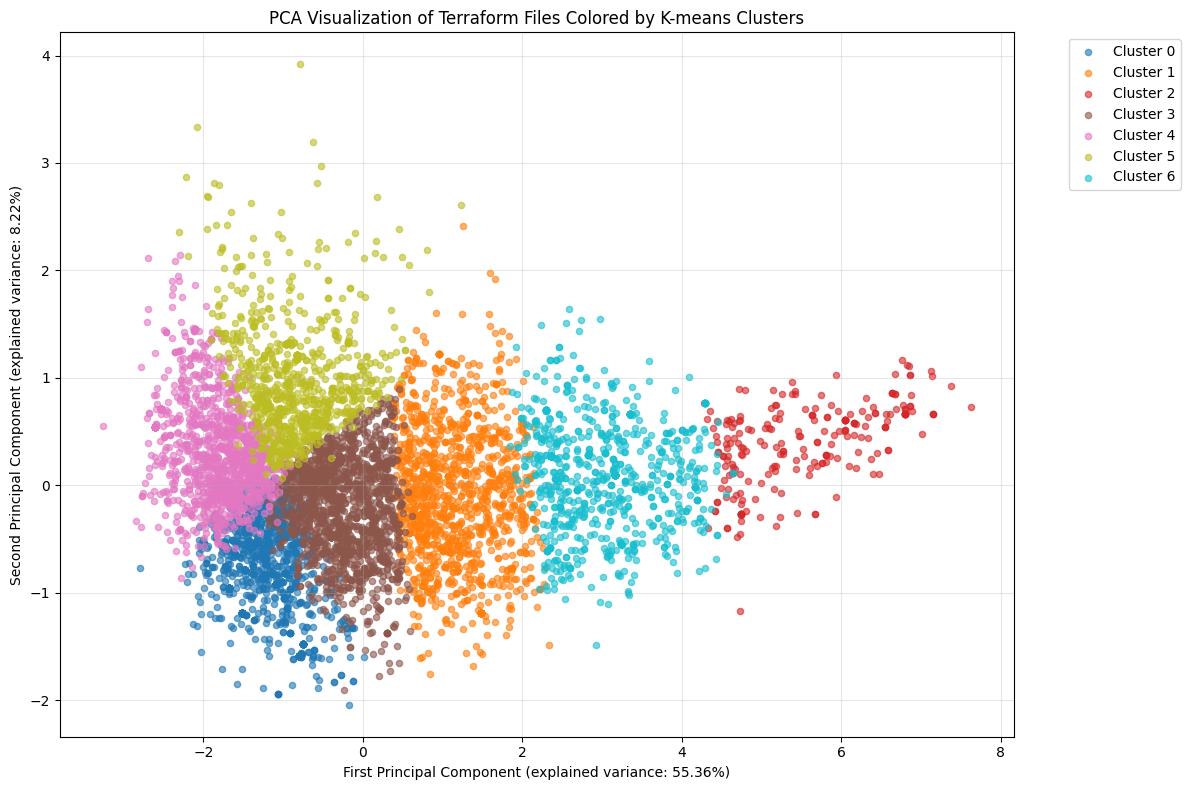


PCA Statistics:
Explained variance ratio: [0.5535998  0.08219692]
Total explained variance: 63.58%
Singular values: [158.66293   61.137165]

Cluster centers in PCA space:
Cluster 0: (-1.233, -0.787)
Cluster 1: (1.171, -0.138)
Cluster 2: (5.544, 0.393)
Cluster 3: (-0.245, -0.210)
Cluster 4: (-1.867, 0.315)
Cluster 5: (-0.876, 0.982)
Cluster 6: (3.010, 0.090)


In [14]:
# Perform PCA to reduce dimensionality to 2D for visualization
print("Performing PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Create a color map for the clusters
colors = plt.cm.tab10(np.linspace(0, 1, 7))

# Create the scatter plot
plt.figure(figsize=(12, 8))
for i in range(7):
    cluster_mask = cluster_labels == i
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)

plt.xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA Visualization of Terraform Files Colored by K-means Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print PCA statistics
print(f"\nPCA Statistics:")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"Singular values: {pca.singular_values_}")

# Print cluster centers in PCA space
cluster_centers_pca = pca.transform(kmeans_10.cluster_centers_)
print(f"\nCluster centers in PCA space:")
for i, center in enumerate(cluster_centers_pca):
    print(f"Cluster {i}: ({center[0]:.3f}, {center[1]:.3f})")

# Labels Analysis within Clusters

=== Label Distribution Analysis Across Clusters ===

Cluster 0:
  Samples: 1222
  Unique labels: 267
  Average labels per sample: 2.04
  Top 5 labels:
    CKV_AWS_218: 521 (42.6%)
    CKV2_OCI_4: 87 (7.1%)
    CKV_ALI_21: 76 (6.2%)
    CKV2_GCP_37: 75 (6.1%)
    CKV2_GCP_14: 75 (6.1%)

Cluster 1:
  Samples: 1312
  Unique labels: 294
  Average labels per sample: 2.66
  Top 5 labels:
    CKV_AWS_218: 204 (15.5%)
    CKV2_AZURE_25: 99 (7.5%)
    CKV2_AWS_37: 99 (7.5%)
    CKV2_AZURE_39: 94 (7.2%)
    CKV2_AZURE_26: 94 (7.2%)

Cluster 2:
  Samples: 231
  Unique labels: 72
  Average labels per sample: 3.32
  Top 5 labels:
    CKV_ALI_13: 53 (22.9%)
    CKV2_AZURE_21: 53 (22.9%)
    CKV2_AZURE_16: 53 (22.9%)
    CKV_ALI_14: 53 (22.9%)
    CKV2_AWS_22: 53 (22.9%)

Cluster 3:
  Samples: 1640
  Unique labels: 327
  Average labels per sample: 2.71
  Top 5 labels:
    CKV_AWS_218: 344 (21.0%)
    CKV_AWS_20: 114 (7.0%)
    CKV_ALI_13: 90 (5.5%)
    CKV2_AZURE_21: 83 (5.1%)
    CKV2_AZURE_16: 81 (

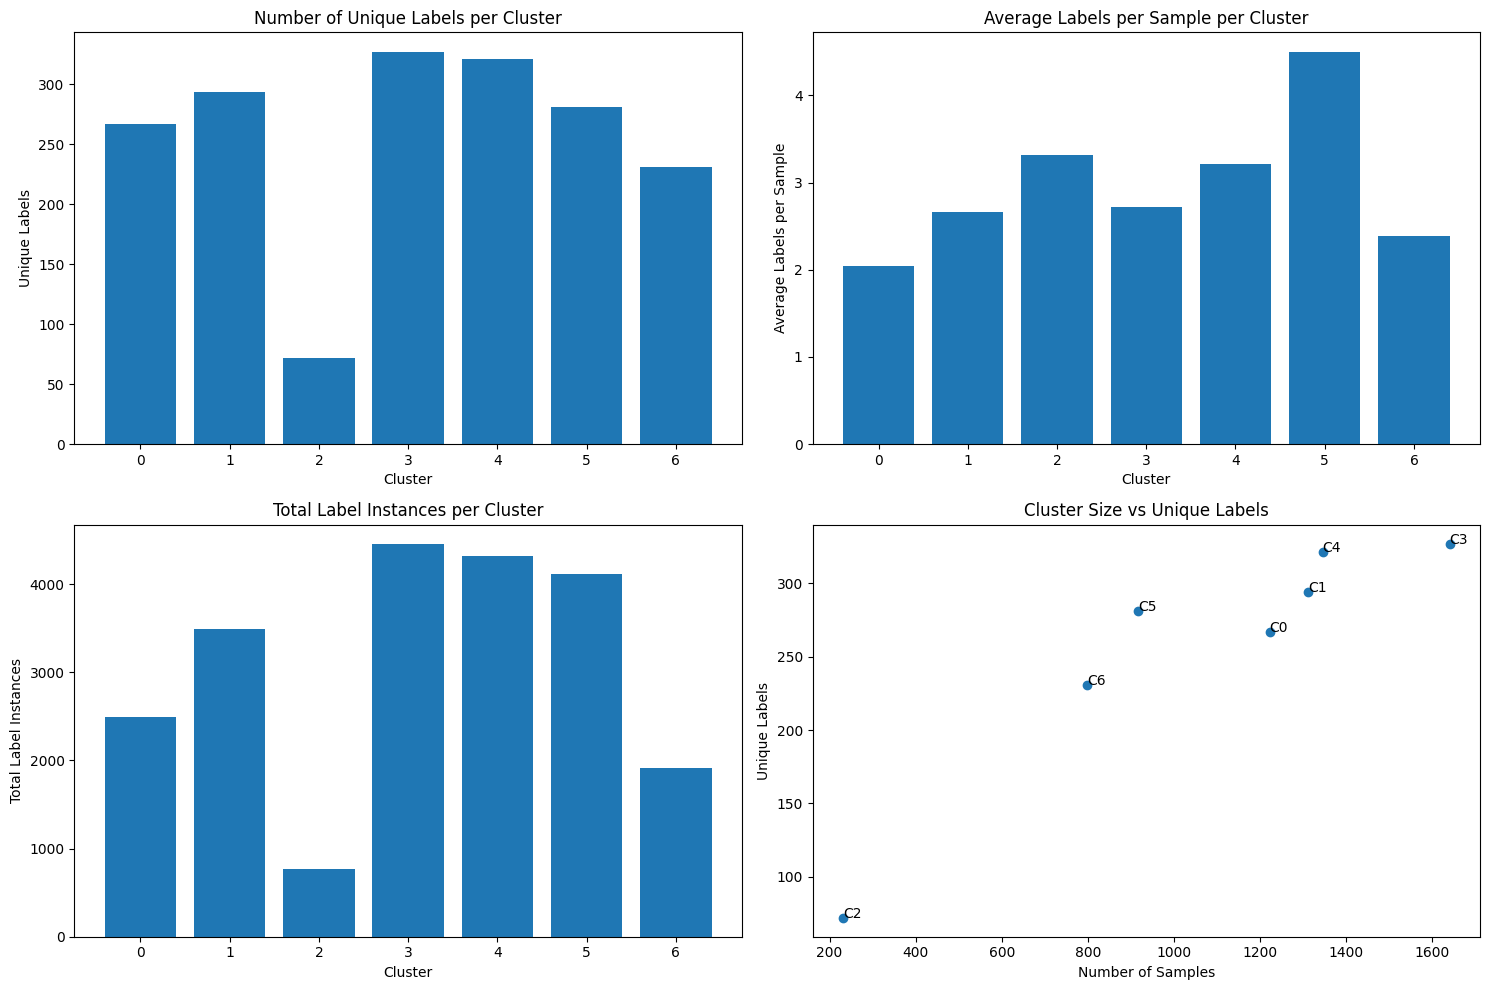


=== Creating Cluster-Label Heatmap ===


IndexError: index 1035 is out of bounds for axis 1 with size 335

In [23]:
# Analyze label distribution across clusters
print("=== Label Distribution Analysis Across Clusters ===\n")

# Create a DataFrame to store cluster-label analysis
cluster_label_analysis = []

for cluster_id in range(7):
    cluster_mask = cluster_labels == cluster_id
    cluster_samples = y_matrix[cluster_mask]
    
    # Get number of samples in this cluster
    n_samples = cluster_samples.shape[0]
    
    # Calculate label frequencies in this cluster
    label_frequencies = cluster_samples.sum(axis=0)
    
    # Get unique labels (labels that appear at least once)
    unique_labels_in_cluster = (label_frequencies > 0).sum()
    
    # Get most common labels in this cluster
    top_labels_indices = np.argsort(label_frequencies)[-10:][::-1]  # Top 10 labels
    top_labels_counts = label_frequencies[top_labels_indices]
    
    print(f"Cluster {cluster_id}:")
    print(f"  Samples: {n_samples}")
    print(f"  Unique labels: {unique_labels_in_cluster}")
    print(f"  Average labels per sample: {label_frequencies.sum() / n_samples:.2f}")
    print(f"  Top 5 labels:")
    
    for i in range(min(5, len(top_labels_indices))):
        if top_labels_counts[i] > 0:
            label_name = unique_labels[top_labels_indices[i]]
            count = int(top_labels_counts[i])
            percentage = (count / n_samples) * 100
            print(f"    {label_name}: {count} ({percentage:.1f}%)")
    print()
    
    # Store data for visualization
    cluster_label_analysis.append({
        'cluster': cluster_id,
        'samples': n_samples,
        'unique_labels': unique_labels_in_cluster,
        'avg_labels_per_sample': label_frequencies.sum() / n_samples,
        'total_label_instances': int(label_frequencies.sum())
    })

# Create summary DataFrame
cluster_summary = pd.DataFrame(cluster_label_analysis)
print("=== Cluster Summary ===")
print(cluster_summary.round(2))

# Visualize cluster-label distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Number of unique labels per cluster
axes[0, 0].bar(cluster_summary['cluster'], cluster_summary['unique_labels'])
axes[0, 0].set_title('Number of Unique Labels per Cluster')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Unique Labels')

# 2. Average labels per sample per cluster
axes[0, 1].bar(cluster_summary['cluster'], cluster_summary['avg_labels_per_sample'])
axes[0, 1].set_title('Average Labels per Sample per Cluster')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Average Labels per Sample')

# 3. Total label instances per cluster
axes[1, 0].bar(cluster_summary['cluster'], cluster_summary['total_label_instances'])
axes[1, 0].set_title('Total Label Instances per Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Total Label Instances')

# 4. Cluster size vs unique labels
axes[1, 1].scatter(cluster_summary['samples'], cluster_summary['unique_labels'])
for i, txt in enumerate(cluster_summary['cluster']):
    axes[1, 1].annotate(f'C{txt}', (cluster_summary['samples'].iloc[i], cluster_summary['unique_labels'].iloc[i]))
axes[1, 1].set_title('Cluster Size vs Unique Labels')
axes[1, 1].set_xlabel('Number of Samples')
axes[1, 1].set_ylabel('Unique Labels')

plt.tight_layout()
plt.show()

# Create a heatmap showing label distribution across clusters
print("\n=== Creating Cluster-Label Heatmap ===")

# Get top 100 most frequent labels overall for better visualization
top_100_global_indices = np.argsort([label_counts[label] for label in unique_labels])[-30:][::-1]
top_100_labels = [unique_labels[i] for i in top_100_global_indices]

# Create matrix for heatmap
cluster_label_matrix = np.zeros((7, 30))
for cluster_id in range(7):
    cluster_mask = cluster_labels == cluster_id
    cluster_samples = y_matrix[cluster_mask]
    
    for i, label_idx in enumerate(top_100_global_indices):
        cluster_label_matrix[cluster_id, i] = cluster_samples[:, label_idx].sum()

# Create heatmap
plt.figure(figsize=(25, 16))
sns.heatmap(cluster_label_matrix, 
            xticklabels=top_100_labels,
            yticklabels=[f'Cluster {i}' for i in range(7)],
            annot=True, 
            fmt='.0f',
            cmap='YlOrRd')
plt.title('Top 20 Labels Distribution Across Clusters')
plt.xlabel('Labels')
plt.ylabel('Clusters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
# Analyze most common labels for each cluster
print("=== Most Common Labels per Cluster ===\n")

for cluster_id in range(7):
    cluster_mask = cluster_labels == cluster_id
    cluster_samples = y_matrix[cluster_mask]
    
    # Get number of samples in this cluster
    n_samples = cluster_samples.shape[0]
    
    # Calculate label frequencies in this cluster
    label_frequencies = cluster_samples.sum(axis=0)
    
    # Get top 5 most common labels
    top_5_indices = np.argsort(label_frequencies)[-5:][::-1]
    
    print(f"Cluster {cluster_id} ({n_samples} samples):")
    print(f"  Most common labels:")
    
    for i, label_idx in enumerate(top_5_indices):
        if label_frequencies[label_idx] > 0:
            label_name = unique_labels[label_idx]
            count = int(label_frequencies[label_idx])
            percentage = (count / n_samples) * 100
            print(f"    {i+1}. {label_name}: {count} ({percentage:.1f}%)")
        else:
            break
    print()

=== Most Common Labels per Cluster ===

Cluster 0 (1222 samples):
  Most common labels:
    1. CKV_TF_1: 521 (42.6%)
    2. CKV_AWS_58: 87 (7.1%)
    3. CKV_AZURE_10: 76 (6.2%)
    4. CKV_AWS_290: 75 (6.1%)
    5. CKV_AWS_355: 75 (6.1%)

Cluster 1 (1312 samples):
  Most common labels:
    1. CKV_TF_1: 204 (15.5%)
    2. CKV2_AWS_62: 99 (7.5%)
    3. CKV_AWS_144: 99 (7.5%)
    4. CKV_AWS_145: 94 (7.2%)
    5. CKV_AWS_18: 94 (7.2%)

Cluster 2 (231 samples):
  Most common labels:
    1. CKV_AWS_135: 53 (22.9%)
    2. CKV_AWS_126: 53 (22.9%)
    3. CKV_AWS_8: 53 (22.9%)
    4. CKV_AWS_79: 53 (22.9%)
    5. CKV2_AWS_41: 53 (22.9%)

Cluster 3 (1640 samples):
  Most common labels:
    1. CKV_TF_1: 344 (21.0%)
    2. CKV_K8S_21: 114 (7.0%)
    3. CKV_AWS_79: 90 (5.5%)
    4. CKV_AWS_135: 83 (5.1%)
    5. CKV_AWS_126: 81 (4.9%)

Cluster 4 (1345 samples):
  Most common labels:
    1. CKV_AWS_273: 197 (14.6%)
    2. CKV_TF_1: 167 (12.4%)
    3. CKV_AWS_23: 119 (8.8%)
    4. CKV_AWS_382: 102 (7.6%

# TSNE + Visualization

Performing t-SNE for visualization...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.295s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.619231
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.904633
[t-SNE] KL divergence after 2000 iterations: 1.296317


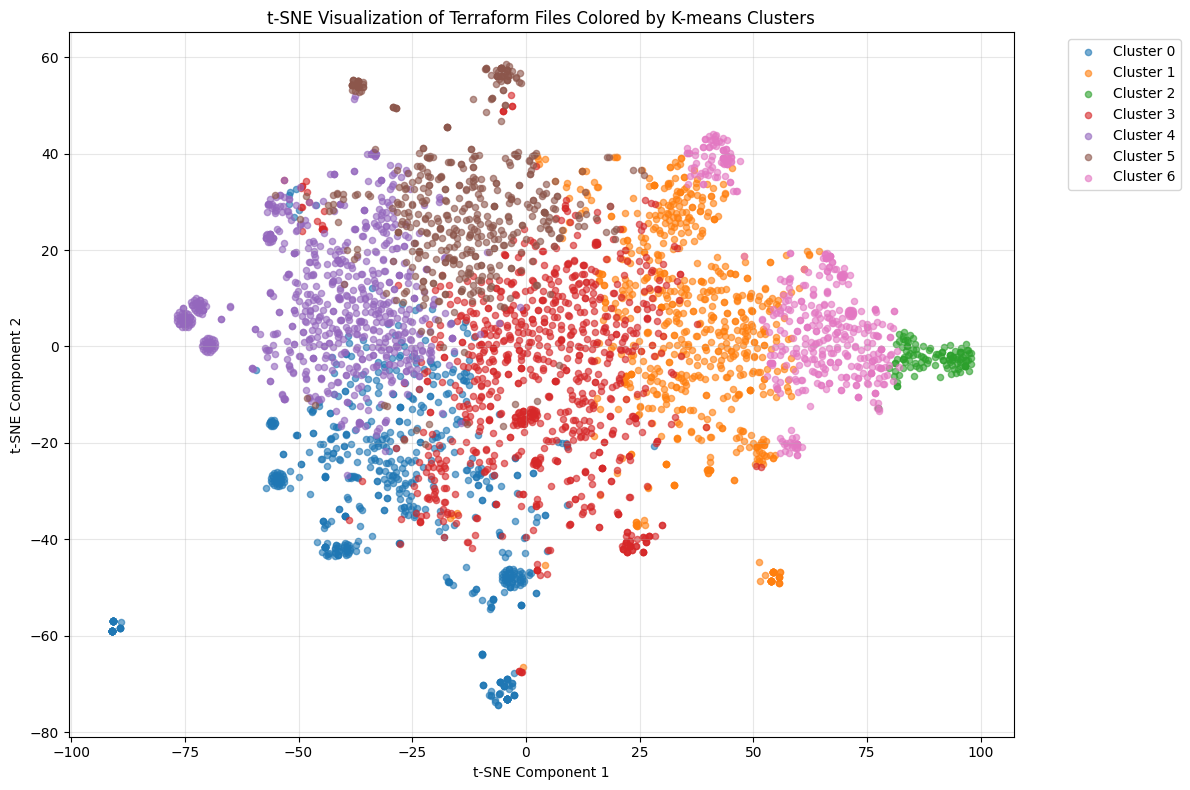


t-SNE Statistics:
Subset size used: 4000
Final KL divergence: 1.2963
Number of iterations: 1999

Cluster distribution in t-SNE subset:
Cluster 0: 663 samples (16.6%)
Cluster 1: 707 samples (17.7%)
Cluster 2: 114 samples (2.9%)
Cluster 3: 871 samples (21.8%)
Cluster 4: 715 samples (17.9%)
Cluster 5: 493 samples (12.3%)
Cluster 6: 437 samples (10.9%)


In [20]:


# Perform t-SNE to reduce dimensionality to 2D for visualization
print("Performing t-SNE for visualization...")
# Use a subset of data for t-SNE as it's computationally expensive
subset_size = min(4000, len(X))  # Use at most 2000 samples
indices = np.random.choice(len(X), subset_size, replace=False)
X_subset = X[indices]
cluster_labels_subset = cluster_labels[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=2000, n_iter_without_progress=300, verbose=1)
X_tsne = tsne.fit_transform(X_subset)

# Create a color map for the clusters
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Create the scatter plot
plt.figure(figsize=(12, 8))
for i in range(7):
    cluster_mask = cluster_labels_subset == i
    plt.scatter(X_tsne[cluster_mask, 0], X_tsne[cluster_mask, 1], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Terraform Files Colored by K-means Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nt-SNE Statistics:")
print(f"Subset size used: {subset_size}")
print(f"Final KL divergence: {tsne.kl_divergence_:.4f}")
print(f"Number of iterations: {tsne.n_iter_}")

# Print cluster distribution in subset
subset_cluster_counts = np.bincount(cluster_labels_subset)
print(f"\nCluster distribution in t-SNE subset:")
for i, count in enumerate(subset_cluster_counts):
    if count > 0:
        print(f"Cluster {i}: {count} samples ({count/len(cluster_labels_subset)*100:.1f}%)")

# Co-occurrence Matrix Analysis for Multi-Label Classification

## 🔗 Understanding Label Relationships

A **co-occurrence matrix** reveals how frequently pairs of labels appear together in the same samples. This analysis is particularly valuable for multi-label problems because it uncovers hidden patterns and dependencies between different misconfigurations.

## 🎯 Why Co-occurrence Analysis Matters

### 1. **Label Dependencies Discovery**
- Reveals which labels tend to co-occur, indicating potential dependencies or correlations
- Helps identify cascading misconfigurations where one issue leads to another

### 2. **Feature Engineering Opportunities**
- Create new features that capture label relationships
- Improve model performance by encoding these dependencies

### 3. **Model Architecture Guidance**
Informs the choice between different multi-label approaches:
- 🔸 **Binary Relevance**: Treats labels independently (ignores co-occurrence)
- 🔸 **Classifier Chains**: Considers label dependencies sequentially
- 🔸 **Label Powerset**: Considers label combinations as new classes

### 4. **Error Analysis & Debugging**
- Identifies which label combinations are hardest to predict
- Highlights areas requiring domain expertise or additional data

### 5. **Data Quality Assessment**
- Unusual co-occurrence patterns might indicate labeling errors
- Validates consistency in data collection processes

## 🌍 Terraform-Specific Insights

For Infrastructure-as-Code misconfigurations, co-occurrence analysis can reveal:

- **🔒 Security Patterns**: Related security checks that often fail together
- **☁️ Cloud Provider Dependencies**: Platform-specific misconfiguration clusters  
- **🏗️ Infrastructure Components**: Services that commonly have related issues
- **📋 Compliance Requirements**: Regulatory checks that are interdependent

## 📊 Interactive Visualization Benefits

The interactive heatmap provides:
- **Hover Details**: Exact co-occurrence counts for label pairs
- **Pattern Recognition**: Visual identification of strong correlations
- **Scalable Exploration**: Efficient analysis of large label spaces

In [21]:
y_matrix = y_matrix_clean
X = X_clean

In [22]:
# Compute co-occurrence matrix
co_occurrence = np.dot(y_matrix.T, y_matrix)

# Add cluster-based analysis
print("=== Computing Cluster-Enhanced Co-occurrence Analysis ===")

# 1. Compute cluster-specific co-occurrence matrices
cluster_co_occurrences = {}
for cluster_id in range(7):  # We have 7 clusters
    cluster_mask = cluster_labels == cluster_id
    if cluster_mask.sum() > 0:  # Only if cluster has samples
        cluster_y = y_matrix[cluster_mask]
        cluster_co_occurrences[cluster_id] = np.dot(cluster_y.T, cluster_y)

# 2. Create cluster-weighted co-occurrence matrix
# Weight by cluster importance (size or other metric)
cluster_sizes = [np.sum(cluster_labels == i) for i in range(7)]
weighted_co_occurrence = np.zeros_like(co_occurrence)

for cluster_id, cluster_co_occ in cluster_co_occurrences.items():
    weight = cluster_sizes[cluster_id] / len(cluster_labels)  # Normalize by cluster size
    weighted_co_occurrence += weight * cluster_co_occ

# 3. Create subplot with cluster information
fig = go.Figure()

# Add main co-occurrence heatmap
fig.add_trace(go.Heatmap(
    z=co_occurrence,
    colorscale=[
        [0.0, 'white'],
        [0.02, 'lightblue'],
        [0.1, 'blue'],
        [0.3, 'darkblue'],
        [0.7, 'red'],
        [1.0, 'darkred']
    ],
    hoverongaps=False,
    hovertemplate='Label %{x} & Label %{y}<br>Co-occurrence: %{z}<br>Cluster Info: Mixed<extra></extra>',
    zmin=0,
    zmax=500,
    name="Global Co-occurrence"
))

# Add cluster size annotation as text overlay
cluster_annotations = []
for i in range(min(100, len(unique_labels))):  # Top 100 labels for visibility
    for j in range(min(100, len(unique_labels))):
        # Find which cluster this label pair is most common in
        max_cluster = -1
        max_count = 0
        for cluster_id, cluster_co_occ in cluster_co_occurrences.items():
            if cluster_co_occ[top_100_global_indices[i], top_100_global_indices[j]] > max_count:
                max_count = cluster_co_occ[top_100_global_indices[i], top_100_global_indices[j]]
                max_cluster = cluster_id
        
        if max_count > 5:  # Only show significant co-occurrences
            cluster_annotations.append(
                dict(
                    x=j, y=i,
                    text=f"C{max_cluster}",
                    showarrow=False,
                    font=dict(color="white", size=8),
                    bgcolor="rgba(0,0,0,0.5)"
                )
            )

fig.update_layout(
    title='Label Co-occurrence Matrix with Cluster Information<br><sub>Text overlays show dominant cluster (C0-C6)</sub>',
    xaxis_title='Label Index (Top 100)',
    yaxis_title='Label Index (Top 100)',
    width=900,
    height=900,
    annotations=cluster_annotations,
    xaxis=dict(range=[-0.5, 19.5]),
    yaxis=dict(range=[-0.5, 19.5])
)

# Restrict to top 100 for better visibility
fig.data[0].z = co_occurrence[top_100_global_indices][:, top_100_global_indices][:100, :100]

fig.show()

# 4. Create separate cluster-specific co-occurrence plots
fig_clusters = go.Figure()

# Create dropdown menu for different clusters
buttons = []
for cluster_id in range(7):
    if cluster_id in cluster_co_occurrences:
        cluster_co_occ = cluster_co_occurrences[cluster_id]
        # Show top 100 labels for this cluster
        cluster_top100 = cluster_co_occ[top_100_global_indices][:, top_100_global_indices][:100, :100]

        buttons.append(dict(
            method="update",
            label=f"Cluster {cluster_id} ({cluster_sizes[cluster_id]} samples)",
            args=[{"z": [cluster_top100]},
                  {"title": f"Co-occurrence Matrix - Cluster {cluster_id}<br><sub>{cluster_sizes[cluster_id]} samples</sub>"}]
        ))

# Add initial heatmap (Cluster 0)
if 0 in cluster_co_occurrences:
    initial_data = cluster_co_occurrences[0][top_100_global_indices][:, top_100_global_indices][:100, :100]
else:
    initial_data = np.zeros((100, 100))

fig_clusters.add_trace(go.Heatmap(
    z=initial_data,
    colorscale=[
        [0.0, 'white'],
        [0.02, 'lightblue'],
        [0.1, 'blue'],
        [0.3, 'darkblue'],
        [0.7, 'red'],
        [1.0, 'darkred']
    ],
    hoverongaps=False,
    hovertemplate='Label %{x} & Label %{y}<br>Co-occurrence: %{z}<extra></extra>',
    zmin=0,
    zmax=100  # Lower max for cluster-specific view
))

fig_clusters.update_layout(
    title=f'Cluster-Specific Co-occurrence Matrix<br><sub>Use dropdown to switch between clusters</sub>',
    xaxis_title='Label Index (Top 100)',
    yaxis_title='Label Index (Top 100)',
    width=800,
    height=800,
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        x=1.0,
        xanchor="left",
        y=1.0,
        yanchor="top",
        buttons=buttons
    )]
)

fig_clusters.show()

fig_normalized = go.Figure()

# Create normalized version of cluster co-occurrences
normalized_cluster_co_occurrences = {}
for cluster_id in range(7):
    if cluster_id in cluster_co_occurrences:
        cluster_co_occ = cluster_co_occurrences[cluster_id]
        # Create normalization matrix
        label_counts_matrix = np.maximum.outer(
            np.diag(cluster_co_occ), 
            np.diag(cluster_co_occ)
        )
        # Avoid division by zero
        label_counts_matrix[label_counts_matrix == 0] = 1
        normalized_cluster_co_occurrences[cluster_id] = cluster_co_occ / label_counts_matrix

# Create dropdown menu for different clusters with normalized values
buttons_normalized = []
for cluster_id in range(7):
    if cluster_id in normalized_cluster_co_occurrences:
        norm_cluster_co_occ = normalized_cluster_co_occurrences[cluster_id]
        # Show top 100 labels for this cluster
        cluster_top100 = norm_cluster_co_occ[top_100_global_indices][:, top_100_global_indices][:100, :100]
        
        buttons_normalized.append(dict(
            method="update",
            label=f"Cluster {cluster_id} ({cluster_sizes[cluster_id]} samples)",
            args=[{"z": [cluster_top100]},
                  {"title": f"Normalized Co-occurrence Matrix - Cluster {cluster_id}<br><sub>{cluster_sizes[cluster_id]} samples</sub>"}]
        ))

# Add initial heatmap (Cluster 0)
if 0 in normalized_cluster_co_occurrences:
    initial_data_norm = normalized_cluster_co_occurrences[0][top_100_global_indices][:, top_100_global_indices][:100, :100]
else:
    initial_data_norm = np.zeros((100, 100))

fig_normalized.add_trace(go.Heatmap(
    z=initial_data_norm,
    colorscale=[
        [0.0, 'white'],
        [0.02, 'lightblue'],
        [0.1, 'blue'],
        [0.3, 'darkblue'],
        [0.7, 'red'],
        [1.0, 'darkred']
    ],
    hoverongaps=False,
    hovertemplate='Label %{x} & Label %{y}<br>Normalized Co-occurrence: %{z:.2f}<extra></extra>',
    zmin=0,
    zmax=1  # Normalized values are between 0 and 1
))

fig_normalized.update_layout(
    title=f'Normalized Cluster-Specific Co-occurrence Matrix<br><sub>Use dropdown to switch between clusters</sub>',
    xaxis_title='Label Index (Top 100)',
    yaxis_title='Label Index (Top 100)',
    width=800,
    height=800,
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        x=1.0,
        xanchor="left",
        y=1.0,
        yanchor="top",
        buttons=buttons_normalized
    )]
)

fig_normalized.show()
#

# 5. Print cluster-specific statistics
print("\n=== Cluster-Specific Co-occurrence Statistics ===")
for cluster_id in range(7):
    if cluster_id in cluster_co_occurrences:
        cluster_co_occ = cluster_co_occurrences[cluster_id]
        max_co_occ = np.max(cluster_co_occ)
        mean_co_occ = np.mean(cluster_co_occ[cluster_co_occ > 0])
        
        print(f"Cluster {cluster_id} ({cluster_sizes[cluster_id]} samples):")
        print(f"  Max co-occurrence: {max_co_occ}")
        print(f"  Mean co-occurrence (non-zero): {mean_co_occ:.2f}")
        
        # Find top co-occurring label pairs in this cluster
        indices = np.unravel_index(np.argsort(-cluster_co_occ.ravel())[:5], cluster_co_occ.shape)
        print(f"  Top 3 co-occurring pairs:")
        for i in range(3):
            label1_idx, label2_idx = indices[0][i], indices[1][i]
            if label1_idx != label2_idx and cluster_co_occ[label1_idx, label2_idx] > 0:
                label1_name = unique_labels[label1_idx] if label1_idx < len(unique_labels) else f"Label_{label1_idx}"
                label2_name = unique_labels[label2_idx] if label2_idx < len(unique_labels) else f"Label_{label2_idx}"
                count = cluster_co_occ[label1_idx, label2_idx]
                print(f"    {label1_name} & {label2_name}: {count}")
        print()


=== Computing Cluster-Enhanced Co-occurrence Analysis ===


IndexError: index 1035 is out of bounds for axis 0 with size 335

# Training and evaluation - Pytorch

In [ ]:

X = torch.load('./data/X_embeddings.pt')
y_matrix = torch.load('./data/y_matrix.pt')
X = X.squeeze(1)  # Remove redundant dimension
X = X.detach().numpy()
y_matrix = y_matrix.detach().numpy()

# Benchmark models 

In [ ]:

# Prepare data for traditional models
X_numpy = X
y_numpy = y_matrix

# Stratified split for multi-label data
print("Performing stratified multi-label split...")
X_train_trad, y_train_trad, X_val_trad, y_val_trad = iterative_train_test_split(
    X_numpy, y_numpy, test_size=0.2
)

print(f"Training set shape: {X_train_trad.shape}, {y_train_trad.shape}")
print(f"Validation set shape: {X_val_trad.shape}, {y_val_trad.shape}")

# Check label distribution
print("\nLabel distribution in training set:")
print(f"Mean labels per sample: {y_train_trad.sum(axis=1).mean():.2f}")
print(f"Labels frequency: {y_train_trad.sum(axis=0)}")

print("\nLabel distribution in validation set:")
print(f"Mean labels per sample: {y_val_trad.sum(axis=1).mean():.2f}")
print(f"Labels frequency: {y_val_trad.sum(axis=0)}")

# Create experiment folder
experiment_folder = create_experiment_folder()
print(f"\nExperiment folder created: {experiment_folder}")

# Train all models
traditional_results = train_traditional_models(
    X_train_trad, X_val_trad, y_train_trad, y_val_trad,
    models_to_train=['lgbm', 'xgb', 'catboost']
)

# Save experiment data
save_experiment_data(traditional_results, experiment_folder)

# Compare results
print("\n=== Model Comparison ===")
comparison_data = []
for model_name, results in traditional_results.items():
    comparison_data.append({
        'Model': model_name.upper(),
        'F1': results['f1'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'Training Time (s)': results['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))

In [ ]:
# -----------------------------
# Dataset Wrapper
# -----------------------------
class MisconfigDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X.squeeze(1)  # Remove redundant dimension
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -----------------------------
# Classifier Chain Dataset
# -----------------------------
class ClassifierChainDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor, previous_predictions: torch.Tensor = None):
        self.X = X.squeeze(1) if X.dim() > 2 else X
        self.y = y
        self.previous_predictions = previous_predictions
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if self.previous_predictions is not None:
            # Concatenate original features with previous predictions
            features = torch.cat([self.X[idx], self.previous_predictions[idx]], dim=0)
        else:
            features = self.X[idx]
        return features, self.y[idx]


# -----------------------------
# Model Definition
# -----------------------------
class ResidualClassifier(nn.Module):
    def __init__(self, input_dim: int, num_labels: int, 
                 hidden_dims: list = [512, 512], 
                 dropout_rate: float = 0.3,
                 residual_connections: bool = True):
        """
        Initialize a modular classifier with configurable architecture.
        
        Args:
            input_dim: Input feature dimension
            num_labels: Number of output labels
            hidden_dims: List of hidden layer dimensions
            dropout_rate: Dropout probability
            residual_connections: Whether to use residual connections
        """
        super().__init__()
        
        # Input validation
        if not hidden_dims:
            raise ValueError("Must specify at least one hidden dimension")
            
        # Build layers dynamically
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        for dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim
            
        self.out = nn.Linear(prev_dim, num_labels)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)
        self.residual = residual_connections
        
    def forward(self, x):
        # Pass through hidden layers with residual connections if enabled
        prev_x = x
        for i, layer in enumerate(self.layers):
            x = self.relu(layer(x))
            x = self.drop(x)
            
            # Add residual connection if dimensions match
            if self.residual and i > 0 and x.shape == prev_x.shape:
                x = x + prev_x
            prev_x = x
                
        return self.out(x)  # Raw logits


# -----------------------------
# Binary Classifier for Chain
# -----------------------------
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list = [256, 128], dropout_rate: float = 0.3):
        super().__init__()
        
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        for dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim
            
        self.out = nn.Linear(prev_dim, 1)  # Single output for binary classification
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
            x = self.drop(x)
        return self.out(x)  # Raw logit


# -----------------------------
# Classifier Chain Implementation
# -----------------------------
class ClassifierChain:
    def __init__(self, input_dim: int, num_labels: int, 
                 hidden_dims: list = [256, 128], 
                 dropout_rate: float = 0.3,
                 chain_order: List[int] = None,
                 device: str = 'cpu'):
        """
        Initialize Classifier Chain.
        
        Args:
            input_dim: Original input feature dimension
            num_labels: Total number of labels
            hidden_dims: Hidden layer dimensions for each binary classifier
            dropout_rate: Dropout rate
            chain_order: Order of labels in the chain (if None, uses 0,1,2,...)
            device: Device to run on
        """
        self.input_dim = input_dim
        self.num_labels = num_labels
        self.device = device
        self.chain_order = chain_order if chain_order is not None else list(range(num_labels))
        
        # Create binary classifiers for each label
        self.classifiers = []
        for i, label_idx in enumerate(self.chain_order):
            # Input dimension increases as we add previous predictions
            current_input_dim = input_dim + i
            classifier = BinaryClassifier(current_input_dim, hidden_dims, dropout_rate).to(device)
            self.classifiers.append(classifier)
    
    def train_chain(self, X_train: torch.Tensor, y_train: torch.Tensor,
                   X_val: torch.Tensor, y_val: torch.Tensor,
                   num_epochs: int = 50, learning_rate: float = 0.001,
                   batch_size: int = 64, patience: int = 5):
        """
        Train the classifier chain.
        """
        results = []
        
        for i, (classifier, label_idx) in enumerate(zip(self.classifiers, self.chain_order)):
            print(f"\nTraining classifier {i+1}/{len(self.classifiers)} for label {label_idx}")
            
            # Get previous predictions for training set
            if i == 0:
                train_prev_preds = None
                val_prev_preds = None
            else:
                train_prev_preds = torch.zeros(X_train.shape[0], i, device=self.device)
                val_prev_preds = torch.zeros(X_val.shape[0], i, device=self.device)
                
                # Get predictions from previous classifiers
                with torch.no_grad():
                    for j in range(i):
                        prev_classifier = self.classifiers[j]
                        prev_label_idx = self.chain_order[j]
                        
                        # For training, use true labels (teacher forcing)
                        train_prev_preds[:, j] = y_train[:, prev_label_idx]
                        
                        # For validation, use predictions
                        if j == 0:
                            val_features = X_val
                        else:
                            val_features = torch.cat([X_val, val_prev_preds[:, :j]], dim=1)
                        
                        val_logits = prev_classifier(val_features)
                        val_prev_preds[:, j] = torch.sigmoid(val_logits).squeeze()
            
            # Create datasets
            train_dataset = ClassifierChainDataset(X_train, y_train[:, label_idx], train_prev_preds)
            val_dataset = ClassifierChainDataset(X_val, y_val[:, label_idx], val_prev_preds)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Train this classifier
            optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
            loss_fn = nn.BCEWithLogitsLoss()
            
            best_f1 = 0
            patience_counter = 0
            best_state = None
            
            for epoch in range(num_epochs):
                # Training
                classifier.train()
                train_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device).float()
                    
                    optimizer.zero_grad()
                    logits = classifier(batch_X).squeeze()
                    loss = loss_fn(logits, batch_y)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                
                # Validation
                classifier.eval()
                val_preds = []
                val_true = []
                val_loss = 0
                
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device).float()
                        logits = classifier(batch_X).squeeze()
                        loss = loss_fn(logits, batch_y)
                        val_loss += loss.item()
                        
                        probs = torch.sigmoid(logits)
                        preds = (probs > 0.5).float()
                        val_preds.append(preds.cpu())
                        val_true.append(batch_y.cpu())
                
                val_preds = torch.cat(val_preds).numpy()
                val_true = torch.cat(val_true).numpy()
                
                f1 = f1_score(val_true, val_preds, zero_division=0)
                
                if (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, "
                          f"Val Loss={val_loss/len(val_loader):.4f}, F1={f1:.4f}")
                
                # Early stopping
                if f1 > best_f1:
                    best_f1 = f1
                    best_state = copy.deepcopy(classifier.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            
            # Load best model
            if best_state is not None:
                classifier.load_state_dict(best_state)
            
            results.append({
                'label_idx': label_idx,
                'best_f1': best_f1,
                'classifier': classifier
            })
            
        return results
    
    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        Make predictions using the classifier chain.
        """
        X = X.to(self.device)
        predictions = torch.zeros(X.shape[0], self.num_labels, device=self.device)
        
        with torch.no_grad():
            for i, (classifier, label_idx) in enumerate(zip(self.classifiers, self.chain_order)):
                # Prepare input features
                if i == 0:
                    features = X
                else:
                    # Use previous predictions as additional features
                    prev_preds = predictions[:, self.chain_order[:i]]
                    features = torch.cat([X, prev_preds], dim=1)
                
                # Get prediction
                logits = classifier(features).squeeze()
                probs = torch.sigmoid(logits)
                predictions[:, label_idx] = probs
        
        return predictions
    
    def predict_binary(self, X: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
        """
        Make binary predictions using the classifier chain.
        """
        probs = self.predict(X)
        return (probs > threshold).float()


# -----------------------------
# Training & Evaluation Functions (Updated)
# -----------------------------
def train_epoch(model, dataloader, optimizer, loss_fn, device, writer, epoch):
    model.train()
    total_loss = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
        
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Log training metrics per iteration
        writer.add_scalar('Loss/train_step', loss.item(), epoch * len(dataloader) + batch_idx)
        if batch_idx % 100 == 0:  # Log predictions every 100 batches
            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).int()
                f1 = f1_score(y_batch.cpu().numpy(), preds.cpu().numpy(), average='macro', zero_division=0)
                writer.add_scalar('F1/train_step', f1, epoch * len(dataloader) + batch_idx)

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device) -> Tuple[float, float, float, float]:
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()
            logits = model(X_batch)
            loss = F.binary_cross_entropy_with_logits(logits, y_batch)
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu()
            preds = (probs > 0.5).int()
            y_true.append(y_batch.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    accuracy = np.mean(y_true == y_pred)
    
    return f1, precision, recall, accuracy, total_loss / len(dataloader)

def evaluate_chain(chain: ClassifierChain, X_test: torch.Tensor, y_test: torch.Tensor) -> dict:
    """
    Evaluate classifier chain performance.
    """
    predictions = chain.predict_binary(X_test)
    y_true = y_test.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    accuracy = np.mean(y_true == y_pred)
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    }

def train_model(num_epochs=100, patience=5,
                train_loader=None, val_loader=None,
                optimizer=None, loss_fn=None, device=None):
    writer = SummaryWriter('runs/misconfig_classifier')
    
    best_model = None
    best_f1 = 0
    patience_counter = 0
    
    # Track metrics history
    history = {
        'train_loss': [], 'val_loss': [],
        'f1': [], 'precision': [], 'recall': [], 'accuracy': []
    }

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device, writer, epoch)
        f1, precision, recall, accuracy, val_loss = evaluate(model, val_loader, device)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1'].append(f1)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['accuracy'].append(accuracy)
        
        # Log to tensorboard
        writer.add_scalar('Loss/train_epoch', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Metrics/F1', f1, epoch)
        writer.add_scalar('Metrics/Precision', precision, epoch)
        writer.add_scalar('Metrics/Recall', recall, epoch)
        writer.add_scalar('Metrics/Accuracy', accuracy, epoch)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | F1={f1:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | Accuracy={accuracy:.4f}")
        
        # Early stopping logic
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model,
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': {
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'accuracy': accuracy
                },
                'history': history
            }, './best_model.pth')
            print(f"Best model saved with F1={best_f1:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model before returning
    checkpoint = torch.load('./best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    writer.close()
    return model, history

# -----------------------------
# Classifier Chain Implementation (Modified)
# -----------------------------
class ClassifierChainModified:
    def __init__(self, input_dim: int, num_labels: int, 
                 hidden_dims: list = [256, 128], 
                 dropout_rate: float = 0.3,
                 chain_order: List[int] = None,
                 device: str = 'cpu'):
        """
        Initialize Classifier Chain.
        
        Args:
            input_dim: Original input feature dimension
            num_labels: Total number of labels
            hidden_dims: Hidden layer dimensions for each binary classifier
            dropout_rate: Dropout rate
            chain_order: Order of labels in the chain (if None, uses 0,1,2,...)
            device: Device to run on
        """
        self.input_dim = input_dim
        self.num_labels = num_labels
        self.device = device
        self.chain_order = chain_order if chain_order is not None else list(range(num_labels))
        
        # Create binary classifiers for each label
        self.classifiers = []
        for i, label_idx in enumerate(self.chain_order):
            # Input dimension increases as we add ALL previous predictions (0 to i-1)
            current_input_dim = input_dim + i
            classifier = BinaryClassifier(current_input_dim, hidden_dims, dropout_rate).to(device)
            self.classifiers.append(classifier)
    
    def train_chain(self, X_train: torch.Tensor, y_train: torch.Tensor,
                   X_val: torch.Tensor, y_val: torch.Tensor,
                   num_epochs: int = 50, learning_rate: float = 0.001,
                   batch_size: int = 64, patience: int = 5):
        """
        Train the classifier chain.
        """
        results = []
        
        for i, (classifier, label_idx) in enumerate(zip(self.classifiers, self.chain_order)):
            print(f"\nTraining classifier {i+1}/{len(self.classifiers)} for label {label_idx}")
            
            # Get ALL previous predictions for training set (from classifiers 0 to i-1)
            if i == 0:
                train_prev_preds = None
                val_prev_preds = None
            else:
                train_prev_preds = torch.zeros(X_train.shape[0], i, device=self.device)
                val_prev_preds = torch.zeros(X_val.shape[0], i, device=self.device)
                
                # Get predictions from ALL previous classifiers (0 to i-1)
                with torch.no_grad():
                    for j in range(i):
                        prev_classifier = self.classifiers[j]
                        prev_label_idx = self.chain_order[j]
                        
                        # For training, use true labels (teacher forcing)
                        train_prev_preds[:, j] = y_train[:, prev_label_idx]
                        
                        # For validation, use predictions from ALL previous classifiers
                        if j == 0:
                            val_features = X_val
                        else:
                            # Concatenate original features with ALL previous predictions (0 to j-1)
                            val_features = torch.cat([X_val, val_prev_preds[:, :j]], dim=1)
                        
                        val_logits = prev_classifier(val_features)
                        val_prev_preds[:, j] = torch.sigmoid(val_logits).squeeze()
            
            # Create datasets
            train_dataset = ClassifierChainDataset(X_train, y_train[:, label_idx], train_prev_preds)
            val_dataset = ClassifierChainDataset(X_val, y_val[:, label_idx], val_prev_preds)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Train this classifier
            optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
            loss_fn = nn.BCEWithLogitsLoss()
            
            best_f1 = 0
            patience_counter = 0
            best_state = None
            
            for epoch in range(num_epochs):
                # Training
                classifier.train()
                train_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device).float()
                    
                    optimizer.zero_grad()
                    logits = classifier(batch_X).squeeze()
                    loss = loss_fn(logits, batch_y)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                
                # Validation
                classifier.eval()
                val_preds = []
                val_true = []
                val_loss = 0
                
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device).float()
                        logits = classifier(batch_X).squeeze()
                        loss = loss_fn(logits, batch_y)
                        val_loss += loss.item()
                        
                        probs = torch.sigmoid(logits)
                        preds = (probs > 0.5).float()
                        val_preds.append(preds.cpu())
                        val_true.append(batch_y.cpu())
                
                val_preds = torch.cat(val_preds).numpy()
                val_true = torch.cat(val_true).numpy()
                
                f1 = f1_score(val_true, val_preds, zero_division=0)
                
                if (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, "
                          f"Val Loss={val_loss/len(val_loader):.4f}, F1={f1:.4f}")
                
                # Early stopping
                if f1 > best_f1:
                    best_f1 = f1
                    best_state = copy.deepcopy(classifier.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            
            # Load best model
            if best_state is not None:
                classifier.load_state_dict(best_state)
            
            results.append({
                'label_idx': label_idx,
                'best_f1': best_f1,
                'classifier': classifier
            })
            
        return results
    
    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        Make predictions using the classifier chain.
        """
        X = X.to(self.device)
        predictions = torch.zeros(X.shape[0], self.num_labels, device=self.device)
        
        with torch.no_grad():
            for i, (classifier, label_idx) in enumerate(zip(self.classifiers, self.chain_order)):
                # Prepare input features with ALL previous predictions (0 to i-1)
                if i == 0:
                    features = X
                else:
                    # Use ALL previous predictions as additional features
                    prev_preds = predictions[:, self.chain_order[:i]]
                    features = torch.cat([X, prev_preds], dim=1)
                
                # Get prediction
                logits = classifier(features).squeeze()
                probs = torch.sigmoid(logits)
                predictions[:, label_idx] = probs
        
        return predictions
    
    def predict_binary(self, X: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
        """
        Make binary predictions using the classifier chain.
        """
        probs = self.predict(X)
        return (probs > threshold).float()




# Training Chain MultiLabel Classification

In [ ]:

# Example usage for classifier chain:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert your data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_matrix, dtype=torch.float32)  # Your multi-label target
if y_tensor.dim() == 1:
    y_tensor = y_tensor.unsqueeze(1)  # Ensure it's 2D for multi-label
# Split data using stratified multi-label splitting

# Simple random split instead of stratified
train_indices = torch.randperm(len(X_tensor))
split_idx = int(0.8 * len(X_tensor))

train_idx = train_indices[:split_idx]
val_idx = train_indices[split_idx:]

X_train = X_tensor[train_idx]
y_train = y_tensor[train_idx]
X_val = X_tensor[val_idx]
y_val = y_tensor[val_idx]


# Convert back to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
# Initialize and train classifier chain
chain = ClassifierChain(
    input_dim=X_tensor.shape[1], 
    num_labels=y_tensor.shape[1],
    hidden_dims=[256, 128],
    device=device
)

# Train the chain
results = chain.train_chain(X_train, y_train, X_val, y_val,patience = 50,num_epochs=100)

# Evaluate
metrics = evaluate_chain(chain, X_val, y_val)
print(f"Chain F1: {metrics['f1']:.4f}")

# Training Regular DNN For Multi Label Classification

In [ ]:
dataset = MisconfigDataset(X, y_matrix)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 100
lr = 1e-3
model = ResidualClassifier(input_dim=X.shape[-1], num_labels=y_matrix.shape[1],hidden_dims=[128,128,128,128],
                           dropout_rate=0.1,residual_connections=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()
patience = 10
model, history = train_model(num_epochs=num_epochs, patience=patience,
                    train_loader=train_loader, val_loader=val_loader,
                    optimizer=optimizer, loss_fn=loss_fn, device=device)


In [ ]:


# Print summary
count_parameters(model)

# Get weights vector
weights_vector = get_weights_vector(model)
print(f'\nWeights vector shape: {weights_vector.shape}')

# Different Approaches for Embeddings 

## Pytorch Embedding Layer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support

# Define the model (Label Embedding Model)
class LabelEmbeddingModel(nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(LabelEmbeddingModel, self).__init__()
        # Embedding layer to represent labels as dense vectors
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Classifier layer to output probabilities for each label
        self.fc = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, label_indices):
        # Pass label indices through the embedding layer
        embedded_labels = self.embedding(label_indices)
        
        # Apply classifier to output probabilities (sigmoid for multi-label)
        output = torch.sigmoid(self.fc(embedded_labels))
        return output

# Initialize model parameters
num_classes = 1061
embedding_dim = 32
model = LabelEmbeddingModel(num_classes=num_classes, embedding_dim=embedding_dim)

# Example dummy data (labels and multi-hot encoded labels)
# We will simulate a small dataset where each sample has a multi-hot label vector (random labels).
# This should be replaced by your actual dataset.
batch_size = 8
labels = torch.randint(0, 2, (batch_size, num_classes)).float()  # Multi-hot encoded labels (random)
label_indices = torch.randint(0, num_classes, (batch_size,))  # Random label indices for input (one-hot style)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(label_indices)  # Pass label indices through the model
    
    # Calculate loss
    loss = criterion(outputs, labels)  # Compare predicted probabilities to true multi-hot labels
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Validation (Optional: Calculate metrics after every epoch)
    model.eval()
    with torch.no_grad():
        predictions = (outputs > 0.5).float()  # Apply threshold to get binary predictions
        precision, recall, f1, _ = precision_recall_fscore_support(labels.numpy(), predictions.numpy(), average='macro')
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


In [ ]:
embedding = model.embedding.weight.data.cpu().numpy()
print(f"Label embedding shape: {embedding.shape}")

## Matrix Factorization (SVD)

In [ ]:
from sklearn.decomposition import TruncatedSVD


# Apply SVD to factorize the label matrix
svd = TruncatedSVD(n_components=256)
y_embeddings = svd.fit_transform(y_matrix)  # Reduced dimension embedding for labels

# Convert to PyTorch tensor for use in the model
y_embeddings_tensor = torch.tensor(y_embeddings, dtype=torch.float32)

print("SVD Embeddings shape:", y_embeddings_tensor.shape)  # Should be (7500, 128)

In [ ]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Apply SVD to factorize the label matrix
svd = TruncatedSVD(n_components=256)
y_embeddings = svd.fit_transform(y_matrix)  # Reduced dimension embedding for labels

# Explained variance ratio
explained_variance = svd.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance
import matplotlib.pyplot as plt
plt.plot(range(1, 257), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of SVD Components')
plt.show()

print("Explained Variance:", cumulative_explained_variance[-1])  # Should be close to 1


In [ ]:
from sklearn.model_selection import train_test_split

# Define a regression model for predicting label embeddings
class LabelEmbeddingRegressor(nn.Module):
    def __init__(self, input_dim: int, embedding_dim: int, 
                 hidden_dims: list = [512, 512, 256], 
                 dropout_rate: float = 0.3,
                 residual_connections: bool = True):
        """
        Regression model to predict label embeddings instead of binary labels.
        
        Args:
            input_dim: Input feature dimension
            embedding_dim: Target embedding dimension (from SVD)
            hidden_dims: List of hidden layer dimensions
            dropout_rate: Dropout probability
            residual_connections: Whether to use residual connections
        """
        super().__init__()
        
        if not hidden_dims:
            raise ValueError("Must specify at least one hidden dimension")
            
        # Build layers dynamically
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        for dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim
            
        # Output layer - no activation since we're predicting continuous values
        self.out = nn.Linear(prev_dim, embedding_dim)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)
        self.residual = residual_connections
        
    def forward(self, x):
        # Pass through hidden layers with residual connections if enabled
        prev_x = x
        for i, layer in enumerate(self.layers):
            x = self.relu(layer(x))
            x = self.drop(x)
            
            # Add residual connection if dimensions match
            if self.residual and i > 0 and x.shape == prev_x.shape:
                x = x + prev_x
            prev_x = x
                
        return self.out(x)  # Raw continuous values (no activation)


# Dataset for regression
class EmbeddingRegressionDataset(Dataset):
    def __init__(self, X: torch.Tensor, y_embeddings: torch.Tensor):
        self.X = X.squeeze(1) if X.dim() > 2 else X
        self.y_embeddings = y_embeddings

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_embeddings[idx]


# Training function for regression
def train_regression_epoch(model, dataloader, optimizer, loss_fn, device, writer, epoch):
    model.train()
    total_loss = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
        
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Log training metrics per iteration
        writer.add_scalar('Loss/train_step', loss.item(), epoch * len(dataloader) + batch_idx)

    return total_loss / len(dataloader)


# Evaluation function for regression - only MSE loss
def evaluate_regression(model, dataloader, device):
    model.eval()
    total_mse_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()
            
            predictions = model(X_batch)
            mse_loss = F.mse_loss(predictions, y_batch)
            total_mse_loss += mse_loss.item()

    return total_mse_loss / len(dataloader)


# Training loop for regression model
def train_regression_model(model, train_loader, val_loader,
                          num_epochs=100, learning_rate=0.001, patience=10, device='cpu'):
    writer = SummaryWriter('runs/embedding_regressor')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    best_model = None
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Track metrics history
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        train_loss = train_regression_epoch(model, train_loader, optimizer, loss_fn, device, writer, epoch)
        val_loss = evaluate_regression(model, val_loader, device)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Log to tensorboard
        writer.add_scalar('Loss/train_epoch', train_loss, epoch)
        writer.add_scalar('Loss/val_mse', val_loss, epoch)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.6f} | Val Loss={val_loss:.6f}")
        
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'history': history
            }, './best_regression_model.pth')
            print(f"Best model saved with Val Loss={best_val_loss:.6f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model before returning
    checkpoint = torch.load('./best_regression_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    writer.close()
    return model, history


# Prepare data for regression
print("Preparing data for embedding regression...")

# Use the SVD embeddings as targets
X_tensor = torch.tensor(X, dtype=torch.float32)
y_embeddings_tensor = torch.tensor(y_embeddings, dtype=torch.float32)

print(f"Input shape: {X_tensor.shape}")
print(f"Target embeddings shape: {y_embeddings_tensor.shape}")

# Stratified split for regression data

# Use stratified split based on the original binary labels
# First, we need to create a stratification key from the binary labels
# We'll use the sum of labels per sample as a proxy for stratification
# y_binary = (y_embeddings != 0).any(axis=1)  # Check if any embedding values are non-zero
# stratify_key = y_binary.astype(int)

# # Perform stratified split
# X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
#     X_tensor, 
#     y_embeddings_tensor,
#     test_size=0.2,
#     stratify=stratify_key,
#     random_state=42
# )

# # Split data
train_indices = torch.randperm(len(X_tensor))
split_idx = int(0.8 * len(X_tensor))

train_idx = train_indices[:split_idx]
val_idx = train_indices[split_idx:]

X_train_reg = X_tensor[train_idx]
y_train_reg = y_embeddings_tensor[train_idx]
X_val_reg = X_tensor[val_idx] 
y_val_reg = y_embeddings_tensor[val_idx]

print(f"Training set: X={X_train_reg.shape}, y_embeddings={y_train_reg.shape}")
print(f"Validation set: X={X_val_reg.shape}, y_embeddings={y_val_reg.shape}")

# Create datasets and dataloaders
train_dataset_reg = EmbeddingRegressionDataset(X_train_reg, y_train_reg)
val_dataset_reg = EmbeddingRegressionDataset(X_val_reg, y_val_reg)

batch_size = 256
train_loader_reg = DataLoader(train_dataset_reg, batch_size=batch_size, shuffle=True)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=batch_size)

# Initialize regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = y_embeddings.shape[1]  # Should be 256 from SVD

regression_model = LabelEmbeddingRegressor(
    input_dim=X.shape[-1], 
    embedding_dim=embedding_dim,
    hidden_dims=[512,512,512],
    dropout_rate=0.1,
    residual_connections=False
).to(device)

print(f"Regression model created with embedding dimension: {embedding_dim}")
count_parameters(regression_model)

# Train the regression model
print("\nTraining embedding regression model...")
regression_model, regression_history = train_regression_model(
    model=regression_model,
    train_loader=train_loader_reg,
    val_loader=val_loader_reg,
    num_epochs=1000,
    learning_rate=0.0005,
    patience=50,
    device=device
)

print("Training completed!")



In [ ]:
import torch.nn.functional as F

# Label embedding regressor with attention mechanism
class AttentionLabelEmbeddingRegressor(nn.Module):
    def __init__(self, input_dim: int, embedding_dim: int,
                 hidden_dims: list = [512, 512, 256], 
                 dropout_rate: float = 0.3,
                 attention_heads: int = 8,
                 residual_connections: bool = True):
        """
        Regression model with attention mechanism for label embedding prediction.
        
        Args:
            input_dim: Input feature dimension
            embedding_dim: Target embedding dimension (from SVD)
            hidden_dims: List of hidden layer dimensions
            dropout_rate: Dropout probability
            attention_heads: Number of attention heads
            residual_connections: Whether to use residual connections
        """
        super().__init__()
        
        if not hidden_dims:
            raise ValueError("Must specify at least one hidden dimension")
            
        # Build encoder layers
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim
        
        for i, dim in enumerate(hidden_dims):
            self.encoder_layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim
            
        # Multi-head attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dims[-1], 
            num_heads=attention_heads,
            dropout=dropout_rate,
            batch_first=True
        )
        
        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], hidden_dims[-1] // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dims[-1] // 2, embedding_dim)
        )
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.residual = residual_connections
        
    def forward(self, x):
        # Pass through encoder layers
        prev_x = x
        
        for i, layer in enumerate(self.encoder_layers):
            x = self.relu(layer(x))
            x = self.dropout(x)
            
            # Add residual connection if dimensions match
            if self.residual and i > 0 and x.shape == prev_x.shape:
                x = x + prev_x
            prev_x = x
        
        # Apply attention mechanism
        # Reshape for attention (add sequence dimension)
        x_reshaped = x.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        attended_x, attention_weights = self.attention(x_reshaped, x_reshaped, x_reshaped)
        x = attended_x.squeeze(1)  # Remove sequence dimension
        
        # Regression output
        embedding_pred = self.regression_head(x)
        
        return embedding_pred, attention_weights


# Training function for attention model
def train_attention_epoch(model, dataloader, optimizer, loss_fn, device, writer, epoch):
    model.train()
    total_loss = 0
    
    for batch_idx, (X_batch, y_embeddings_batch) in enumerate(dataloader):
        X_batch = X_batch.to(device)
        y_embeddings_batch = y_embeddings_batch.to(device).float()
        
        optimizer.zero_grad()
        
        # Forward pass
        embedding_pred, attention_weights = model(X_batch)
        
        # Calculate loss
        loss = loss_fn(embedding_pred, y_embeddings_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Log training metrics per iteration
        writer.add_scalar('Loss/train_step', loss.item(), 
                         epoch * len(dataloader) + batch_idx)

    return total_loss / len(dataloader)


# Evaluation function for attention model
def evaluate_attention(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X_batch, y_embeddings_batch in dataloader:
            X_batch = X_batch.to(device)
            y_embeddings_batch = y_embeddings_batch.to(device).float()
            
            embedding_pred, _ = model(X_batch)
            
            # Calculate loss
            loss = F.mse_loss(embedding_pred, y_embeddings_batch)
            total_loss += loss.item()

    return total_loss / len(dataloader)


# Training loop for attention model
def train_attention_model(model, train_loader, val_loader, num_epochs=100, 
                         learning_rate=0.001, patience=10, device='cpu'):
    writer = SummaryWriter('runs/attention_regressor')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    best_model = None
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Track metrics history
    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(num_epochs):
        train_loss = train_attention_epoch(
            model, train_loader, optimizer, loss_fn, device, writer, epoch
        )
        
        val_loss = evaluate_attention(model, val_loader, device)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Log to tensorboard
        writer.add_scalar('Loss/train_epoch', train_loss, epoch)
        writer.add_scalar('Loss/val_epoch', val_loss, epoch)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.6f} | Val Loss={val_loss:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'history': history
            }, './best_attention_model.pth')
            print(f"Best model saved with Val Loss={best_val_loss:.6f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model before returning
    checkpoint = torch.load('./best_attention_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    writer.close()
    return model, history


# Initialize attention model
attention_model = AttentionLabelEmbeddingRegressor(
    input_dim=X.shape[-1],
    embedding_dim=embedding_dim,
    hidden_dims=[512, 512, 512],
    dropout_rate=0.05,
    attention_heads=4,
    residual_connections=False
).to(device)

print(f"Attention model created with embedding dimension: {embedding_dim}")
count_parameters(attention_model)

# Train the attention model
print("\nTraining attention-based embedding regression model...")
attention_model, attention_history = train_attention_model(
    model=attention_model,
    train_loader=train_loader_reg,
    val_loader=val_loader_reg,
    num_epochs=1000,
    learning_rate=0.001,
    patience=50,
    device=device
)

print("Attention model training completed!")


# Sample Weighted Version

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Define a regression model for predicting label embeddings
class LabelEmbeddingRegressor(nn.Module):
    def __init__(self, input_dim: int, embedding_dim: int, 
                 hidden_dims: list = [512, 512, 256], 
                 dropout_rate: float = 0.3,
                 residual_connections: bool = True):
        """
        Regression model to predict label embeddings instead of binary labels.
        
        Args:
            input_dim: Input feature dimension
            embedding_dim: Target embedding dimension (from SVD)
            hidden_dims: List of hidden layer dimensions
            dropout_rate: Dropout probability
            residual_connections: Whether to use residual connections
        """
        super().__init__()
        
        if not hidden_dims:
            raise ValueError("Must specify at least one hidden dimension")
            
        # Build layers dynamically
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        for dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim
            
        # Output layer - no activation since we're predicting continuous values
        self.out = nn.Linear(prev_dim, embedding_dim)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)
        self.residual = residual_connections
        
    def forward(self, x):
        # Pass through hidden layers with residual connections if enabled
        prev_x = x
        for i, layer in enumerate(self.layers):
            x = self.relu(layer(x))
            x = self.drop(x)
            
            # Add residual connection if dimensions match
            if self.residual and i > 0 and x.shape == prev_x.shape:
                x = x + prev_x
            prev_x = x
                
        return self.out(x)  # Raw continuous values (no activation)


# Dataset for regression with class weights
class EmbeddingRegressionDataset(Dataset):
    def __init__(self, X: torch.Tensor, y_embeddings: torch.Tensor, sample_weights: torch.Tensor = None):
        self.X = X.squeeze(1) if X.dim() > 2 else X
        self.y_embeddings = y_embeddings
        self.sample_weights = sample_weights

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if self.sample_weights is not None:
            return self.X[idx], self.y_embeddings[idx], self.sample_weights[idx]
        return self.X[idx], self.y_embeddings[idx]


# Custom weighted MSE loss
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, predictions, targets, weights=None):
        mse = F.mse_loss(predictions, targets, reduction='none')
        if weights is not None:
            # Apply sample weights
            weighted_mse = mse * weights.unsqueeze(1)
            return weighted_mse.mean()
        return mse.mean()


# Training function for regression with class weights
def train_regression_epoch(model, dataloader, optimizer, loss_fn, device, writer, epoch):
    model.train()
    total_loss = 0
    
    for batch_idx, batch_data in enumerate(dataloader):
        if len(batch_data) == 3:
            X_batch, y_batch, weights_batch = batch_data
            X_batch, y_batch, weights_batch = X_batch.to(device), y_batch.to(device).float(), weights_batch.to(device).float()
        else:
            X_batch, y_batch = batch_data
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            weights_batch = None
        
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch, weights_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Log training metrics per iteration
        writer.add_scalar('Loss/train_step', loss.item(), epoch * len(dataloader) + batch_idx)

    return total_loss / len(dataloader)


# Evaluation function for regression with weights
def evaluate_regression(model, dataloader, device):
    model.eval()
    total_mse_loss = 0
    loss_fn = WeightedMSELoss()
    
    with torch.no_grad():
        for batch_data in dataloader:
            if len(batch_data) == 3:
                X_batch, y_batch, weights_batch = batch_data
                X_batch, y_batch, weights_batch = X_batch.to(device), y_batch.to(device).float(), weights_batch.to(device).float()
            else:
                X_batch, y_batch = batch_data
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
                weights_batch = None
            
            predictions = model(X_batch)
            mse_loss = loss_fn(predictions, y_batch, weights_batch)
            total_mse_loss += mse_loss.item()

    return total_mse_loss / len(dataloader)


# Training loop for regression model with learning rate scheduler
def train_regression_model(model, train_loader, val_loader,
                          num_epochs=100, learning_rate=0.001, patience=10, device='cpu'):
    writer = SummaryWriter('runs/embedding_regressor')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = WeightedMSELoss()
    
    # Add learning rate scheduler - ReduceLROnPlateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',           # Reduce LR when validation loss stops decreasing
        factor=0.9,           # Multiply LR by 0.5
        patience=5,           # Wait 5 epochs before reducing
        min_lr=1e-5,          # Minimum learning rate
    )
    
    best_model = None
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Track metrics history
    history = {'train_loss': [], 'val_loss': [], 'learning_rate': []}

    for epoch in range(num_epochs):
        train_loss = train_regression_epoch(model, train_loader, optimizer, loss_fn, device, writer, epoch)
        val_loss = evaluate_regression(model, val_loader, device)
        
        # Step the scheduler with validation loss
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rate'].append(current_lr)
        
        # Log to tensorboard
        writer.add_scalar('Loss/train_epoch', train_loss, epoch)
        writer.add_scalar('Loss/val_mse', val_loss, epoch)
        writer.add_scalar('Learning_Rate', current_lr, epoch)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.6f} | Val Loss={val_loss:.6f} | LR={current_lr:.2e}")
        
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'history': history
            }, './best_regression_model.pth')
            print(f"Best model saved with Val Loss={best_val_loss:.6f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model before returning
    checkpoint = torch.load('./best_regression_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    writer.close()
    return model, history


# Calculate class frequencies and weights
def calculate_class_weights(y_matrix):
    """Calculate class weights inversely proportional to their frequency"""
    # Calculate frequency of each class
    class_counts = np.sum(y_matrix, axis=0)
    total_samples = y_matrix.shape[0]
    
    # Calculate class frequencies
    class_frequencies = class_counts / total_samples
    
    # Calculate inverse frequencies (add small epsilon to avoid division by zero)
    epsilon = 1e-7
    class_weights = 1.0 / (class_frequencies + epsilon)
    
    # Normalize weights to have mean = 1
    class_weights = class_weights / np.mean(class_weights)
    
    return class_weights


def calculate_sample_weights(y_matrix, class_weights):
    """Calculate sample weights based on the sum of class weights for active labels"""
    sample_weights = np.zeros(y_matrix.shape[0])
    
    for i in range(y_matrix.shape[0]):
        # Find active labels in this sample
        active_labels = np.where(y_matrix[i] > 0)[0]
        
        if len(active_labels) > 0:
            # Sum the weights of active labels
            sample_weights[i] = np.sum(class_weights[active_labels])
        else:
            # If no active labels, use mean weight
            sample_weights[i] = 1.0
    
    return sample_weights


# Prepare data for regression
print("Preparing data for embedding regression...")

# Use the SVD embeddings as targets
X_tensor = torch.tensor(X, dtype=torch.float32)
y_embeddings_tensor = torch.tensor(y_embeddings, dtype=torch.float32)

print(f"Input shape: {X_tensor.shape}")
print(f"Target embeddings shape: {y_embeddings_tensor.shape}")

# Calculate class weights from the available binary labels
print("Calculating class weights...")
# Use y_matrix which exists in your environment
class_weights = calculate_class_weights(y_matrix)
print(f"Using y_matrix for weight calculation")

print(f"Class weights shape: {class_weights.shape}")
print(f"Class weights statistics: min={np.min(class_weights):.4f}, max={np.max(class_weights):.4f}, mean={np.mean(class_weights):.4f}")

# Split data
train_indices = torch.randperm(len(X_tensor))
split_idx = int(0.8 * len(X_tensor))

train_idx = train_indices[:split_idx]
val_idx = train_indices[split_idx:]

X_train_reg = X_tensor[train_idx]
y_train_reg = y_embeddings_tensor[train_idx]
X_val_reg = X_tensor[val_idx] 
y_val_reg = y_embeddings_tensor[val_idx]

# Calculate sample weights for training and validation sets
print("Calculating sample weights...")
# Use y_matrix for weight calculation
y_train_for_weights = y_matrix[train_idx.numpy()]
y_val_for_weights = y_matrix[val_idx.numpy()]

train_sample_weights = calculate_sample_weights(y_train_for_weights, class_weights)
val_sample_weights = calculate_sample_weights(y_val_for_weights, class_weights)

# Convert to tensors
train_sample_weights = torch.tensor(train_sample_weights, dtype=torch.float32)
val_sample_weights = torch.tensor(val_sample_weights, dtype=torch.float32)

print(f"Training set: X={X_train_reg.shape}, y_embeddings={y_train_reg.shape}, weights={train_sample_weights.shape}")
print(f"Validation set: X={X_val_reg.shape}, y_embeddings={y_val_reg.shape}, weights={val_sample_weights.shape}")
print(f"Sample weights statistics - Train: min={torch.min(train_sample_weights):.4f}, max={torch.max(train_sample_weights):.4f}")
print(f"Sample weights statistics - Val: min={torch.min(val_sample_weights):.4f}, max={torch.max(val_sample_weights):.4f}")

# Create datasets and dataloaders with weights
train_dataset_reg = EmbeddingRegressionDataset(X_train_reg, y_train_reg, train_sample_weights)
val_dataset_reg = EmbeddingRegressionDataset(X_val_reg, y_val_reg, val_sample_weights)

batch_size = 128
train_loader_reg = DataLoader(train_dataset_reg, batch_size=batch_size, shuffle=True)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=batch_size)

# Initialize regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = y_embeddings.shape[1]  # Should be 256 from SVD

regression_model = LabelEmbeddingRegressor(
    input_dim=X.shape[-1], 
    embedding_dim=embedding_dim,
    hidden_dims=[1024,1024,1024],
    dropout_rate=0,
    residual_connections=False
).to(device)

print(f"Regression model created with embedding dimension: {embedding_dim}")
count_parameters(regression_model)

# Train the regression model with learning rate scheduler
print("\nTraining embedding regression model with class weights and LR scheduler...")
regression_model, regression_history = train_regression_model(
    model=regression_model,
    train_loader=train_loader_reg,
    val_loader=val_loader_reg,
    num_epochs=1000,
    learning_rate=0.001,
    patience=50,
    device=device
)

print("Training completed!")


In [ ]:
plt.plot(attention_history['train_loss'], label='Train Loss')
plt.plot(attention_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-task Model Training Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(regression_history['train_loss'], label='Train Loss')
plt.plot(regression_history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Embedding Regression Loss')
plt.show()

In [ ]:
regression_model.eval()
with torch.no_grad():
    # Get predictions on validation set
    val_predictions, _ = attention_model(X_val_reg.to(device))
    val_predictions = val_predictions.cpu().numpy()
    # Transform predictions back to original space if needed
    val_predictions_transformed = svd.inverse_transform(val_predictions)  # Inverse SVD to get back to original space
    

In [ ]:
# Min-max normalization of predictions
val_predictions_normalized = (val_predictions_transformed - val_predictions_transformed.min()) / (val_predictions_transformed.max() - val_predictions_transformed.min())

# Create binary predictions with threshold 0.5 on normalized values 
val_predictions_binary = (val_predictions_normalized > 0.3).astype(int)

# Verify the normalization worked
print("Normalized predictions range:")
print(f"Min: {val_predictions_normalized.min()}")
print(f"Max: {val_predictions_normalized.max()}")
print(f"Mean: {val_predictions_normalized.mean():.4f}")

In [ ]:
# Get original validation labels 
y_val_original = y_matrix[val_idx]
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
# Calculate metrics for both micro and macro averaging
micro_f1 = f1_score(y_val_original, val_predictions_binary, average='micro', zero_division=0)
micro_precision = precision_score(y_val_original, val_predictions_binary, average='micro', zero_division=0)
micro_recall = recall_score(y_val_original, val_predictions_binary, average='micro', zero_division=0)
micro_auc = roc_auc_score(y_val_original, val_predictions_binary, average='micro', multi_class='ovr')
# Print also decision boundary that maximizes F1 score
print(f"Decision boundary for F1 score: {0.:.2f}")
macro_f1 = f1_score(y_val_original, val_predictions_binary, average='macro', zero_division=0)
macro_precision = precision_score(y_val_original, val_predictions_binary, average='macro', zero_division=0)
macro_recall = recall_score(y_val_original, val_predictions_binary, average='macro', zero_division=0)
# Print metrics summary
print("\n=== Model Performance Metrics ===")
print("\nMicro-Averaging Metrics:")
print(f"F1 Score: {micro_f1:.4f}")
print(f"Precision: {micro_precision:.4f}")
print(f"Recall: {micro_recall:.4f}")
print(f"AUC: {micro_auc:.4f}")

print("\nMacro-Averaging Metrics:")
print(f"F1 Score: {macro_f1:.4f}")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall: {macro_recall:.4f}")

# Get per-label metrics
label_wise_f1 = f1_score(y_val_original, val_predictions_binary, average=None, zero_division=0)
label_wise_precision = precision_score(y_val_original, val_predictions_binary, average=None, zero_division=0)
label_wise_recall = recall_score(y_val_original, val_predictions_binary, average=None, zero_division=0)

# Create visualization for top 20 labels performance
plt.figure(figsize=(15, 8))
top_20_indices = np.argsort(label_wise_f1)[-20:]
metrics_df = pd.DataFrame({
    'F1 Score': label_wise_f1[top_20_indices],
    'Precision': label_wise_precision[top_20_indices],
    'Recall': label_wise_recall[top_20_indices],
    'Label': [unique_labels[i] for i in top_20_indices]
})

# Plot metrics for top 20 labels
ax = metrics_df.plot(x='Label', kind='bar', width=0.8)
plt.title('Performance Metrics for Top 20 Labels', pad=20)
plt.xlabel('Label')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create confusion matrix heatmap for top 10 most frequent labels
confusion_matrices = multilabel_confusion_matrix(y_val_original, val_predictions_binary)
top_10_freq_indices = np.argsort([np.sum(y_val_original[:, i]) for i in range(len(unique_labels))])[-10:]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, label_idx in enumerate(top_10_freq_indices):
    cm = confusion_matrices[label_idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Label: {unique_labels[label_idx]}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Distribution of number of labels per sample
true_label_counts = np.sum(y_val_original, axis=1)
pred_label_counts = np.sum(val_predictions_binary, axis=1)

plt.figure(figsize=(12, 6))
plt.hist(true_label_counts, alpha=0.5, label='True Labels', bins=20)
plt.hist(pred_label_counts, alpha=0.5, label='Predicted Labels', bins=20)
plt.title('Distribution of Labels per Sample')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Error analysis: Label co-occurrence patterns
fig = go.Figure()

# Create co-occurrence matrix for errors
false_positives = (val_predictions_binary > y_val_original).astype(int)
false_negatives = (y_val_original > val_predictions_binary).astype(int)

# Get top 20 most frequent error combinations
error_combinations = np.dot(false_positives.T, false_positives) + np.dot(false_negatives.T, false_negatives)
top_20_error_pairs = np.unravel_index(np.argsort(error_combinations.ravel())[-400:], error_combinations.shape)

# Create heatmap
fig.add_trace(go.Heatmap(
    z=error_combinations[top_20_error_pairs],
    x=[unique_labels[i] for i in top_20_error_pairs[1]],
    y=[unique_labels[i] for i in top_20_error_pairs[0]],
    colorscale='RdYlBu_r',
    hoverongaps=False
))

fig.update_layout(
    title='Label Co-occurrence in Prediction Errors',
    xaxis_title='Label',
    yaxis_title='Label',
    width=800,
    height=800
)

fig.show()

# Print detailed error analysis for top 10 labels
print("\n=== Detailed Error Analysis for Top 10 Labels ===")
for i, label_idx in enumerate(top_10_freq_indices):
    tn, fp, fn, tp = confusion_matrices[label_idx].ravel()
    total = tn + fp + fn + tp
    error_rate = (fp + fn) / total
    
    print(f"\nLabel: {unique_labels[label_idx]}")
    print(f"Total samples: {total}")
    print(f"True Positives: {tp} ({tp/total*100:.1f}%)")
    print(f"False Positives: {fp} ({fp/total*100:.1f}%)")
    print(f"False Negatives: {fn} ({fn/total*100:.1f}%)")
    print(f"True Negatives: {tn} ({tn/total*100:.1f}%)")
    print(f"Error Rate: {error_rate*100:.1f}%")

In [ ]:
y_val_original[0]

In [ ]:
idx = 342
plt.plot(val_predictions_binary[idx],color='blue', label='Predicted Labels',alpha = 1)
plt.plot(y_val_original[idx], color='red', label='True Labels', linestyle='--',alpha=0.7)
print(f"F1 Score (Macro): {f1_score(y_val_original[idx], val_predictions_binary[idx]):.4f}")
f1_scores = [f1_score(y_val_original[i], val_predictions_binary[i]) for i in range(len(y_val_original))]

In [ ]:
np.mean(f1_scores), np.std(f1_scores)

In [ ]:
# Transform back the validation predictions to binary label format

# Calculate metrics comparing predictions to original validation labels
f1 = f1_score(y_val_reg[:len(val_predictions_binary)].numpy(), val_predictions_binary, average='macro', zero_division=0)
precision = precision_score(y_val_reg[:len(val_predictions_binary)].numpy(), val_predictions_binary, average='macro', zero_division=0)
recall = recall_score(y_val_reg[:len(val_predictions_binary)].numpy(), val_predictions_binary, average='macro', zero_division=0)

print(f"SVD-based Regression Model Performance:")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Check the shape and some statistics
print(f"\nPredictions shape: {val_predictions_binary.shape}")
print(f"Original labels shape: {y_val_reg.shape}")
print(f"Predicted positive labels per sample (mean): {val_predictions_binary.sum(axis=1).mean():.2f}")
print(f"True positive labels per sample (mean): {y_val_reg.numpy().sum(axis=1).mean():.2f}")

In [ ]:
val_predictions[0]

In [ ]:
val_predictions_transformed[0].min()

In [ ]:
svd.components_.shape
svd.transform(y_matrix).shape

In [ ]:
# Reconstruct the matrix using the reduced embeddings (U * Sigma * V^T)
reconstructed_matrix = np.dot(svd.transform(y_matrix), svd.components_)

# Compute reconstruction error (e.g., Frobenius norm)
error = np.linalg.norm(y_matrix - reconstructed_matrix, 'fro')
print(f"Reconstruction Error: {error}")


## Autoencoders for Labels

In [ ]:
class LabelAutoencoder(nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(LabelAutoencoder, self).__init__()
        # Encoder: maps the binary label vector to a lower-dimensional embedding
        self.encoder = nn.Sequential(
            nn.Linear(num_classes, embedding_dim),
            nn.ReLU()
        )
        
        # Decoder: reconstructs the label vector from the embedding
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, num_classes),
            nn.Sigmoid()  # Sigmoid for multi-label output (binary values)
        )
    
    def forward(self, x):
        # Encoding the label into continuous vector
        encoded = self.encoder(x)
        # Reconstructing the original label vector
        decoded = self.decoder(encoded)
        return decoded

# Example: Create a random label matrix with 7500 samples and 1061 labels
num_classes = 1061
embedding_dim = 128
labels = torch.randint(0, 2, (7500, num_classes), dtype=torch.float32)

# Instantiate model
autoencoder = LabelAutoencoder(num_classes, embedding_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Example: Training loop for Autoencoder
for epoch in range(10):  # 10 epochs for illustration
    # Forward pass
    output = autoencoder(labels)
    loss = criterion(output, labels)  # Compare reconstructed labels to original
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

## Deep Metric Learning (Contrastive Loss/Triplet Loss)
#### Deep metric learning can learn a label embedding space where labels that are semantically similar are placed closer together. This is done using contrastive loss or triplet loss to train the model.

In [ ]:
import torch.optim as optim

class MetricLearningModel(nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(MetricLearningModel, self).__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.fc = nn.Linear(embedding_dim, embedding_dim)
    
    def forward(self, x):
        # Forward pass for learning label embeddings
        embedded = self.embedding(x)
        output = self.fc(embedded)
        return output

# Contrastive loss function (used for metric learning)
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        # Compute the Euclidean distance between embeddings
        euclidean_distance = torch.sqrt(torch.sum((output1 - output2) ** 2, dim=1))
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + 
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

# Instantiate model
model = MetricLearningModel(num_classes=1061, embedding_dim=128)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy data (pairs of labels and binary labels indicating if they are similar or not)
label_pairs = torch.randint(0, 1061, (100, 2))  # Random pairs of labels
similarity = torch.randint(0, 2, (100,))  # 1 if similar, 0 if dissimilar

# Training loop
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    
    # Get embeddings for label pairs
    label1, label2 = label_pairs[:, 0], label_pairs[:, 1]
    output1 = model(label1)
    output2 = model(label2)
    
    # Compute the contrastive loss
    loss = criterion(output1, output2, similarity)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch}, Loss: {loss.item()}")

## Neural Collaborative Filtering (NCF)
### Neural Collaborative Filtering (NCF) is an approach that is commonly used in recommendation systems. It works by learning embeddings for both the input (features) and output (labels) and then combining them through neural layers. The goal is to predict the interactions (or labels) between the input and the labels using the learned embeddings.

In [ ]:
# Define the NCF model for label embeddings
class NeuralCollaborativeFiltering(nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(NeuralCollaborativeFiltering, self).__init__()
        
        # Embedding layers for both input features and labels
        self.input_embedding = nn.Embedding(num_classes, embedding_dim)
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Neural network layers to combine the embeddings
        self.fc1 = nn.Linear(embedding_dim * 2, embedding_dim)
        self.fc2 = nn.Linear(embedding_dim, 1)  # Single output for multi-label prediction
    
    def forward(self, label_indices, input_features):
        # Get embeddings for labels and input features
        input_embedded = self.input_embedding(input_features)
        label_embedded = self.label_embedding(label_indices)
        
        # Concatenate both embeddings and pass through neural layers
        combined = torch.cat([input_embedded, label_embedded], dim=1)
        x = torch.relu(self.fc1(combined))
        output = torch.sigmoid(self.fc2(x))  # Sigmoid for multi-label classification
        return output

# Initialize the model
embedding_dim = 128
num_classes = 1061
model = NeuralCollaborativeFiltering(num_classes=num_classes, embedding_dim=embedding_dim)

# Dummy input data: label indices (random), and feature indices (random)
label_indices = torch.randint(0, num_classes, (10,))  # 10 random labels (batch size 10)
input_features = torch.randint(0, num_classes, (10,))  # 10 random feature indices

# Forward pass
output = model(label_indices, input_features)
print("Output shape:", output.shape)  # Should be (10, 1) with sigmoid activation for multi-labels
